In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner
import scipy.stats
from scipy.ndimage import gaussian_filter1d
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from fit_just_early_lc import prep_light_curve
from uncertain_x.line_fit import uncertain_x

from multiprocessing import Pool
import time

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path = "../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype_pec.csv")

# Quality Filtering

As shown in the two cells below, while the MCMC model converges for most of the SNe in the early ZTF sample, the quality of those fits are not equal. There does not, however, appear to be a simple way numerical way to filter (examples below of $\chi^2$ filtering, as expected, show that $\chi^2_\nu \approx 1$ for all sources, which is by design given the model). 

Here we look at a few different factors that affect the final model quality (these can all be boiled down to a single effect - gap in coverage, though the precise location of those gaps varies form object to object making a single simple masking or flagging of the data challenging).

#### Example 1

18abauprj has an incredibly nice light curve with really good sampling

<IPython.core.display.Javascript object>


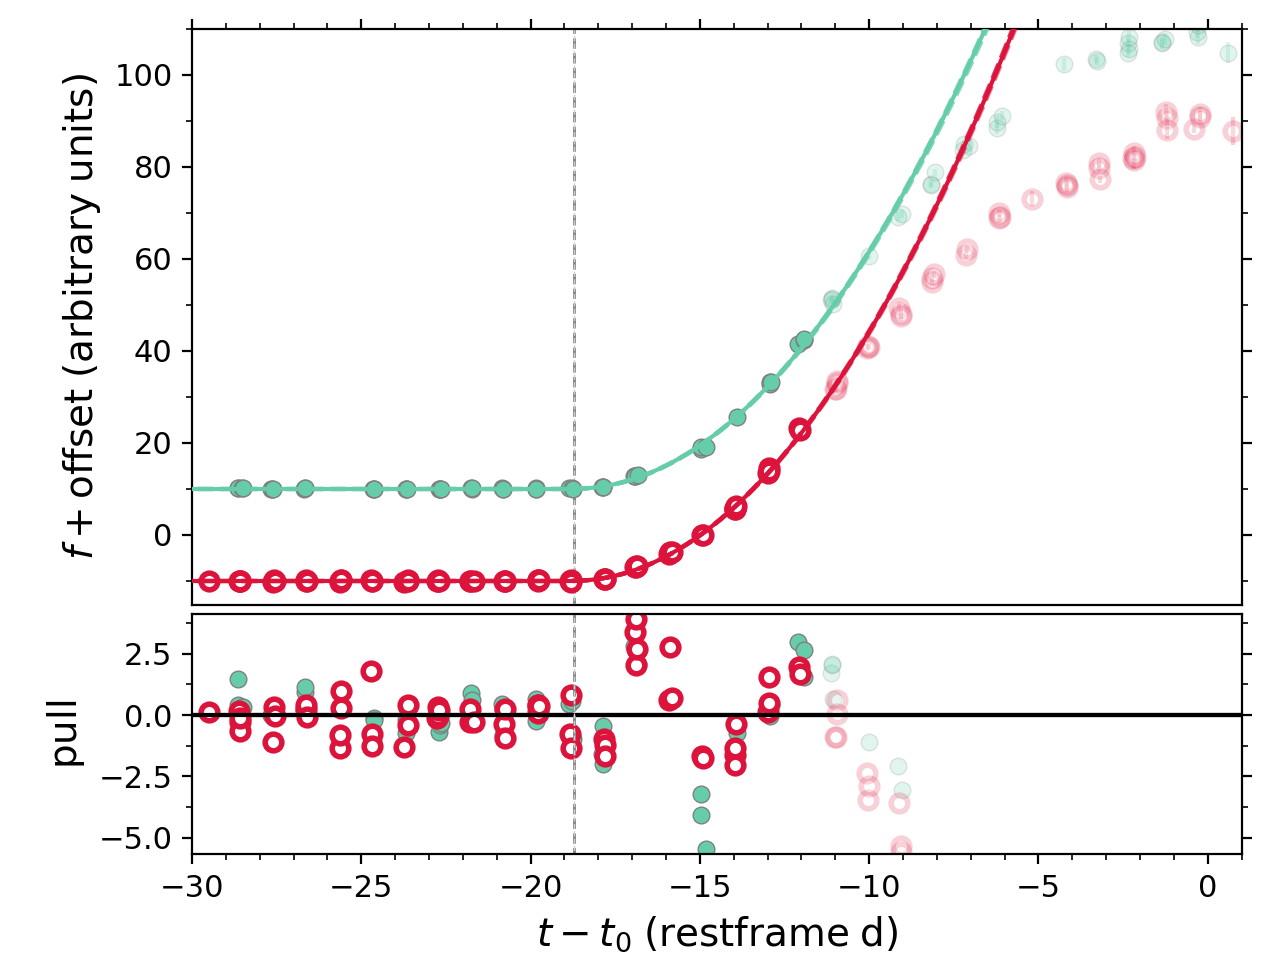

In [28]:
thin_by = 100
rel_flux_cutoff = 0.4

sn = 'ZTF18abauprj'

h5_file = info_path + 'big_unc/{}_emcee_40_tsquared.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)


t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff, 
                                                                     return_masked=True)

adjust_samp = np.zeros((np.shape(samples)[0],2+np.shape(samples)[1]))
for alpha  in [2,4]:
    adjust_samp[:,alpha] = np.ones(len(samples))*2
for param_num in range(len(samples[0])):
    if param_num < 2:
        adjust_samp[:,param_num]  = samples[:,param_num]
    elif param_num == 2:
        adjust_samp[:,param_num+1]  = samples[:,param_num]
    elif param_num > 2:
        adjust_samp[:,param_num+2]  = samples[:,param_num]


max_posterior = adjust_samp[np.argmax(lnpost)]
haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                      adjust_samp, np.random.choice(range(len(samples)), 8, replace=False))

#### Example 2

ZTF18abkudjo has a grabage light curve with very few points on the rise.

<IPython.core.display.Javascript object>


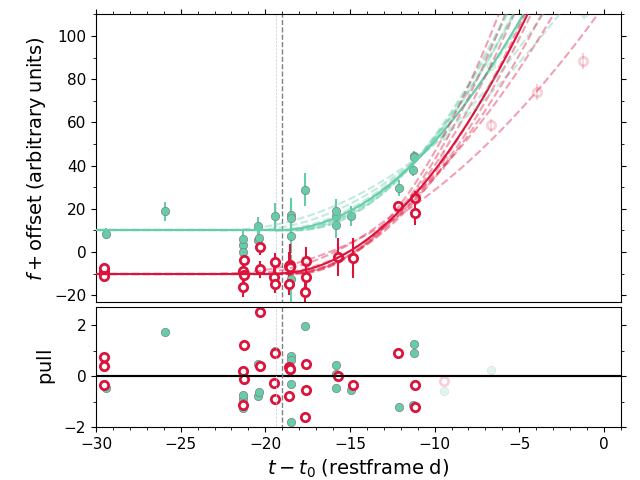

In [29]:
sn = 'ZTF18abkudjo'

h5_file = info_path + 'big_unc/{}_emcee_40_tsquared.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)


t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff, 
                                                                     return_masked=True)

adjust_samp = np.zeros((np.shape(samples)[0],2+np.shape(samples)[1]))
for alpha  in [2,4]:
    adjust_samp[:,alpha] = np.ones(len(samples))*2
for param_num in range(len(samples[0])):
    if param_num < 2:
        adjust_samp[:,param_num]  = samples[:,param_num]
    elif param_num == 2:
        adjust_samp[:,param_num+1]  = samples[:,param_num]
    elif param_num > 2:
        adjust_samp[:,param_num+2]  = samples[:,param_num]


max_posterior = adjust_samp[np.argmax(lnpost)]
haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                      adjust_samp, np.random.choice(range(len(samples)), 8, replace=False))

## Measure the gaps

As alluded to above, the consistent issue with models that do not behave in a particularly SN-like manner is some form of gap in the observations. Below we quantify several different types of gap, and record them for future use.

After that we examine every SN individually, to compile a list of those that should potentially be flagged before including them in any larger analysis. 

In [5]:
frac_fit = 40
rel_flux_cutoff = frac_fit/100

In [22]:
thin_by = 100

name_arr = np.empty(len(salt_df)).astype('S12')
conv_arr = np.zeros(len(salt_df)).astype(bool)
t0_05 = np.zeros(len(salt_df)).astype('float')
t0_16 = np.zeros(len(salt_df)).astype('float')
t0_arr = np.zeros(len(salt_df)).astype('float')
t0_84 = np.zeros(len(salt_df)).astype('float')
t0_95 = np.zeros(len(salt_df)).astype('float')

C_g_16 = np.zeros(len(salt_df)).astype('float')
C_g_arr = np.zeros(len(salt_df)).astype('float')
C_g_84 = np.zeros(len(salt_df)).astype('float')

C_r_16 = np.zeros(len(salt_df)).astype('float')
C_r_arr = np.zeros(len(salt_df)).astype('float')
C_r_84 = np.zeros(len(salt_df)).astype('float')

C2_g_16 = np.zeros(len(salt_df)).astype('float')
C2_g_arr = np.zeros(len(salt_df)).astype('float')
C2_g_84 = np.zeros(len(salt_df)).astype('float')

C2_r_16 = np.zeros(len(salt_df)).astype('float')
C2_r_arr = np.zeros(len(salt_df)).astype('float')
C2_r_84 = np.zeros(len(salt_df)).astype('float')

pre_gap_g = np.zeros(len(salt_df)).astype('float')
pre_gap_r = np.zeros(len(salt_df)).astype('float')
post_gap_g = np.zeros(len(salt_df)).astype('float')
post_gap_r = np.zeros(len(salt_df)).astype('float')
post_max_g = np.zeros(len(salt_df)).astype('float')
post_max_r = np.zeros(len(salt_df)).astype('float')
post_min_g = np.zeros(len(salt_df)).astype('float')
post_min_r = np.zeros(len(salt_df)).astype('float')
delta_t0 = np.zeros(len(salt_df)).astype('float')
n_nights_g_post = np.zeros(len(salt_df)).astype('float')
n_nights_r_post = np.zeros(len(salt_df)).astype('float')
n_nights_gr_post = np.zeros(len(salt_df)).astype('float')

final_selection = np.zeros(len(salt_df)).astype('int')

source_list = []

for filenum, sn in enumerate(salt_df.name.values):
    h5_file = info_path + 'big_unc/{}_emcee_{}_tsquared.h5'.format(sn, frac_fit)
    reader = emcee.backends.HDFBackend(h5_file)
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    name_arr[filenum] = sn
    tau = reader.get_autocorr_time(tol=0)
    if np.all(np.isfinite(tau)):
        print(sn, int(nsteps/np.max(tau)/thin_by), nsteps/thin_by, np.max(tau))
    else:
        print(sn, 'tau is nan')
    if ((np.isfinite(tau).all() and 
         nsteps > int(100*np.max(tau))*thin_by and 
         nsteps < 1000000) or 
        (nsteps == 1000000 and nsteps > int(50*np.max(tau))*thin_by)
       ):
        burnin = int(5*np.max(tau))
        samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
        lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
        
        max_posterior = samples[np.argmax(lnpost)]
        if (max_posterior[3] + max_posterior[1]*max_posterior[0]**2 > 0.9 and 
            max_posterior[5] + max_posterior[2]*max_posterior[0]**2 > 0.9):
            final_selection[filenum] = 1
        
        
        # get the light curve
        lc_df = pd.read_hdf(info_path+"{}_force_phot.h5".format(sn))
        
        t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
        z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
        g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
        r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

        t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                             t_max=t_max, 
                                                                             z=z,
                                                                             g_max=g_max,
                                                                             r_max=r_max,
                                                                             rel_flux_cutoff=rel_flux_cutoff, 
                                                                             return_masked=True)       
        
        if (np.all(np.median(samples, axis=0) < 1e6)):
            conv_arr[filenum] = True
            t0_05[filenum], t0_16[filenum], t0_arr[filenum], t0_84[filenum], t0_95[filenum] = np.percentile(samples[:,0], (5, 16, 50, 84, 95))
            
            C_g_16[filenum], C_g_arr[filenum],  C_g_84[filenum] = np.percentile(samples[:,3], (16, 50, 84))
            C_r_16[filenum], C_r_arr[filenum],  C_r_84[filenum] = np.percentile(samples[:,5], (16, 50, 84))
            if len(samples[0]) >= 11:
                C2_g_16[filenum], C2_g_arr[filenum],  C2_g_84[filenum] = np.percentile(samples[:,7], (16, 50, 84))
                C2_r_16[filenum], C2_r_arr[filenum],  C2_r_84[filenum] = np.percentile(samples[:,9], (16, 50, 84))
#             if len(samples[0]) > 9 and len(samples[0]) != 13:
#                 print(sn)

            # ugly below!
            g_obs = np.array(fcqfid_data % 2).astype(bool)

            pre_gap_g[filenum] = -1*np.max(t_data[g_obs][np.where(t_data[g_obs] - t0_arr[filenum] < 0)] - t0_arr[filenum])
            pre_gap_r[filenum] = -1*np.max(t_data[~g_obs][np.where(t_data[~g_obs] - t0_arr[filenum] < 0)] - t0_arr[filenum])
            post_gap_g[filenum] = np.min(t_data[g_obs][np.where(t_data[g_obs] - t0_arr[filenum] > 0)] - t0_arr[filenum])
            post_gap_r[filenum] = np.min(t_data[~g_obs][np.where(t_data[~g_obs] - t0_arr[filenum] > 0)] - t0_arr[filenum])
            t0_max_aposteri = samples[np.argmax(reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True))][0]
            delta_t0[filenum] = t0_max_aposteri - t0_arr[filenum]
        
            early_t_g = t_data[plot_obs][g_obs[plot_obs]]
            early_f_g = f_data[plot_obs][g_obs[plot_obs]]
            obs_post_g = (1+z)*early_t_g[np.where((early_t_g - t0_arr[filenum]) > 0)]
            early_t_r = t_data[plot_obs][~g_obs[plot_obs]]
            early_f_r = f_data[plot_obs][~g_obs[plot_obs]]
            obs_post_r = (1+z)*early_t_r[np.where((early_t_r - t0_arr[filenum]) > 0)]

            last_obs_of_night_g = np.append(np.where(np.diff(obs_post_g) > 0.5)[0], len(obs_post_g)-1)
            last_obs_of_night_r = np.append(np.where(np.diff(obs_post_r) > 0.5)[0], len(obs_post_r)-1)
            post_with_gr = 0
            for r_night in obs_post_r[last_obs_of_night_r]:
                if len(last_obs_of_night_g) > 0 and len(obs_post_g) > 0:
                    if np.min(np.abs(obs_post_g[last_obs_of_night_g] - r_night)) < 0.33:
                        post_with_gr += 1                       

            n_nights_g_post[filenum] = sum(np.diff(obs_post_g) > 0.5) + 1
            n_nights_r_post[filenum] = sum(np.diff(obs_post_r) > 0.5) + 1            
            n_nights_gr_post[filenum] = post_with_gr
            
            if sum(early_t_g >= t0_arr[filenum]) > 0:
                post_max_g[filenum] = np.max(early_f_g[np.where(early_t_g >= t0_arr[filenum])])
                post_min_g[filenum] = np.min(early_f_g[np.where(early_t_g >= t0_arr[filenum])])
            if sum(early_t_r >= t0_arr[filenum]) > 0:
                post_max_r[filenum] = np.max(early_f_r[np.where(early_t_r >= t0_arr[filenum])])
                post_min_r[filenum] = np.min(early_f_r[np.where(early_t_r >= t0_arr[filenum])])

            
        else:
            print('\t\t', sn, '"converged" but alpha = 1e8, tau=',  int(np.max(tau))*thin_by)
            source_list.append(sn)
    elif np.isfinite(tau).all():
        print('\t\t', "will not converge", sn, nsteps, int(np.max(tau))*thin_by)
        source_list.append(sn)
    else:
        print('\t\t', "tau is NaN", sn)
        source_list.append(sn)

ZTF18aailmnv 304 800.0 2.6292224550783576
ZTF18aansqun 642 1000.0 1.5556273096436355
ZTF18aaoxryq 256 3000.0 11.683863590533091
ZTF18aapqwyv 493 900.0 1.8229980885669175
ZTF18aapsedq 489 800.0 1.6330490897191674
ZTF18aaqcozd 174 900.0 5.157485354163126
ZTF18aaqcqkv 271 3600.0 13.270812497553502
ZTF18aaqcqvr 554 900.0 1.6231724169752648
ZTF18aaqcugm 591 800.0 1.352536883024297
ZTF18aaqffyp 60 10000.0 166.63536211712614
ZTF18aaqnrum 73 10000.0 136.0738687204525
ZTF18aaqqoqs 590 700.0 1.1861032182188422
ZTF18aarldnh 1048 1600.0 1.5265465807113205
ZTF18aarqnje 598 1000.0 1.6695307802693167
ZTF18aasdted 741 900.0 1.2130886096445366
ZTF18aasesgl 565 1000.0 1.7679833106244893
ZTF18aaslhxt 591 1000.0 1.6899137775281794
ZTF18aatzygk 158 10000.0 63.1680104539156
ZTF18aauhxce 556 800.0 1.4387710092141877


/Users/adamamiller/astronomy/ZTF/early_Ia/2018/ztf_early_Ia_2018/playground/fit_just_early_lc.py:490: RuntimeWarning: divide by zero encountered in power
  weights=f_zp_unc_tonight[g_tonight]**(-2))
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/adamamiller/astronomy/ZTF/early_Ia/2018/ztf_early_Ia_2018/playground/fit_just_early_lc.py:493: RuntimeWarning: divide by zero encountered in power
  weights=f_zp_unc_tonight[~g_tonight]**(-2))
/Users/adamamiller/astronomy/ZTF/early_Ia/2018/ztf_early_Ia_2018/playground/fit_just_early_lc.py:495: RuntimeWarning: invalid value encountered in greater
  cutoff_g = np.where((mean_rf < 0) & (mean_g > 0) &
/Users/adamamiller/astronomy/ZTF/early_Ia/2018/ztf_early_Ia_2018/playground/fit_just_early_lc.py:496: RuntimeWarning: invalid value encountered in less
  (mean_g < rel_flux_cu

ZTF18aaumeys 778 1600.0 2.0545001359829573
ZTF18aaumlfl 348 500.0 1.436319103233222
ZTF18aaunfqq 487 1000.0 2.0504586219710514
ZTF18aauocnw 555 900.0 1.6198384603855316
ZTF18aavrwhu 659 800.0 1.213230408636734
ZTF18aavrzxp 504 800.0 1.585264129954978
ZTF18aawjywv 645 800.0 1.2396354266349578
ZTF18aawpcel 667 1000.0 1.4989757490460462
ZTF18aawurud 299 1600.0 5.33761036768938
ZTF18aaxakhh 1403 10000.0 7.125649876029101
ZTF18aaxcntm 662 800.0 1.207535709712383
ZTF18aaxdrjn 808 1600.0 1.979211394876442
ZTF18aaxqyki 412 800.0 1.9403136299451895
ZTF18aaxrvzj 722 1400.0 1.9376286641217453
ZTF18aaxsioa 750 900.0 1.1993933090981272
ZTF18aaxvpsw 402 700.0 1.7406060447046636
ZTF18aaxwjmp 544 900.0 1.6525220954854385
ZTF18aaydmkh 681 900.0 1.320104469969409
ZTF18aayjvve 504 600.0 1.1899474004469548
ZTF18aaykjei 662 800.0 1.208367341240602
ZTF18aaytovs 647 800.0 1.235726609389789
ZTF18aazabmh 487 800.0 1.6407997751665957
ZTF18aazblzy 731 1200.0 1.641194301252773
ZTF18aazcoob 284 500.0 1.75720064205

In [23]:
res_tsquared = pd.DataFrame(data=name_arr, columns=['ztf_name'])

res_tsquared['t0'] = t0_arr
res_tsquared['t0_05'] = t0_05
res_tsquared['t0_16'] = t0_16
res_tsquared['t0_84'] = t0_84
res_tsquared['t0_95'] = t0_95

res_tsquared['pre_gap_g'] = pre_gap_g
res_tsquared['pre_gap_r'] = pre_gap_r
res_tsquared['post_gap_g'] = post_gap_g
res_tsquared['post_gap_r'] = post_gap_r
res_tsquared['delta_t0'] = delta_t0
res_tsquared['post_max_g'] = post_max_g
res_tsquared['post_max_r'] = post_max_r
res_tsquared['post_min_g'] = post_min_g
res_tsquared['post_min_r'] = post_min_r

res_tsquared['n_nights_g_post'] = n_nights_g_post
res_tsquared['n_nights_r_post'] = n_nights_r_post
res_tsquared['n_nights_gr_post'] = n_nights_gr_post
# res_tsquared[''] = 

res_tsquared['conv_arr'] = conv_arr.astype(int)
res_tsquared['final_selection'] = final_selection.astype(int)

res_tsquared.to_csv('results_{}_tsquared.csv'.format(frac_fit), index=False)

<IPython.core.display.Javascript object>


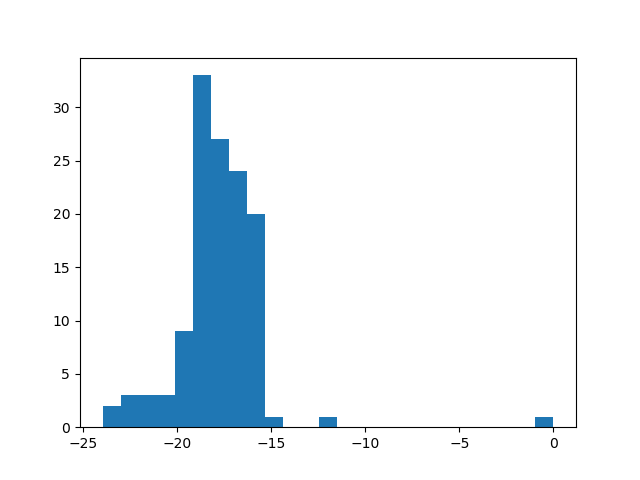

<IPython.core.display.Javascript object>


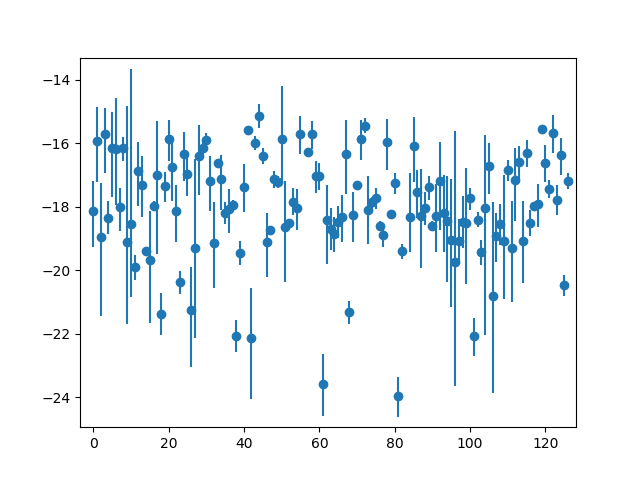

<ErrorbarContainer object of 3 artists>

In [45]:
plt.figure()
plt.hist(t0_arr, bins=25)

plt.figure()
plt.errorbar(range(len(t0_arr)), t0_arr, 
             yerr=np.vstack((t0_arr - t0_05, t0_95 - t0_arr)),
             fmt='o')

### Make Plots

Corner plots, and posterior predictive plots are generated to visually examine whether any of models are problematic given the data (many are! –– MCMC convergence is an insufficient criterion)

<IPython.core.display.Javascript object>


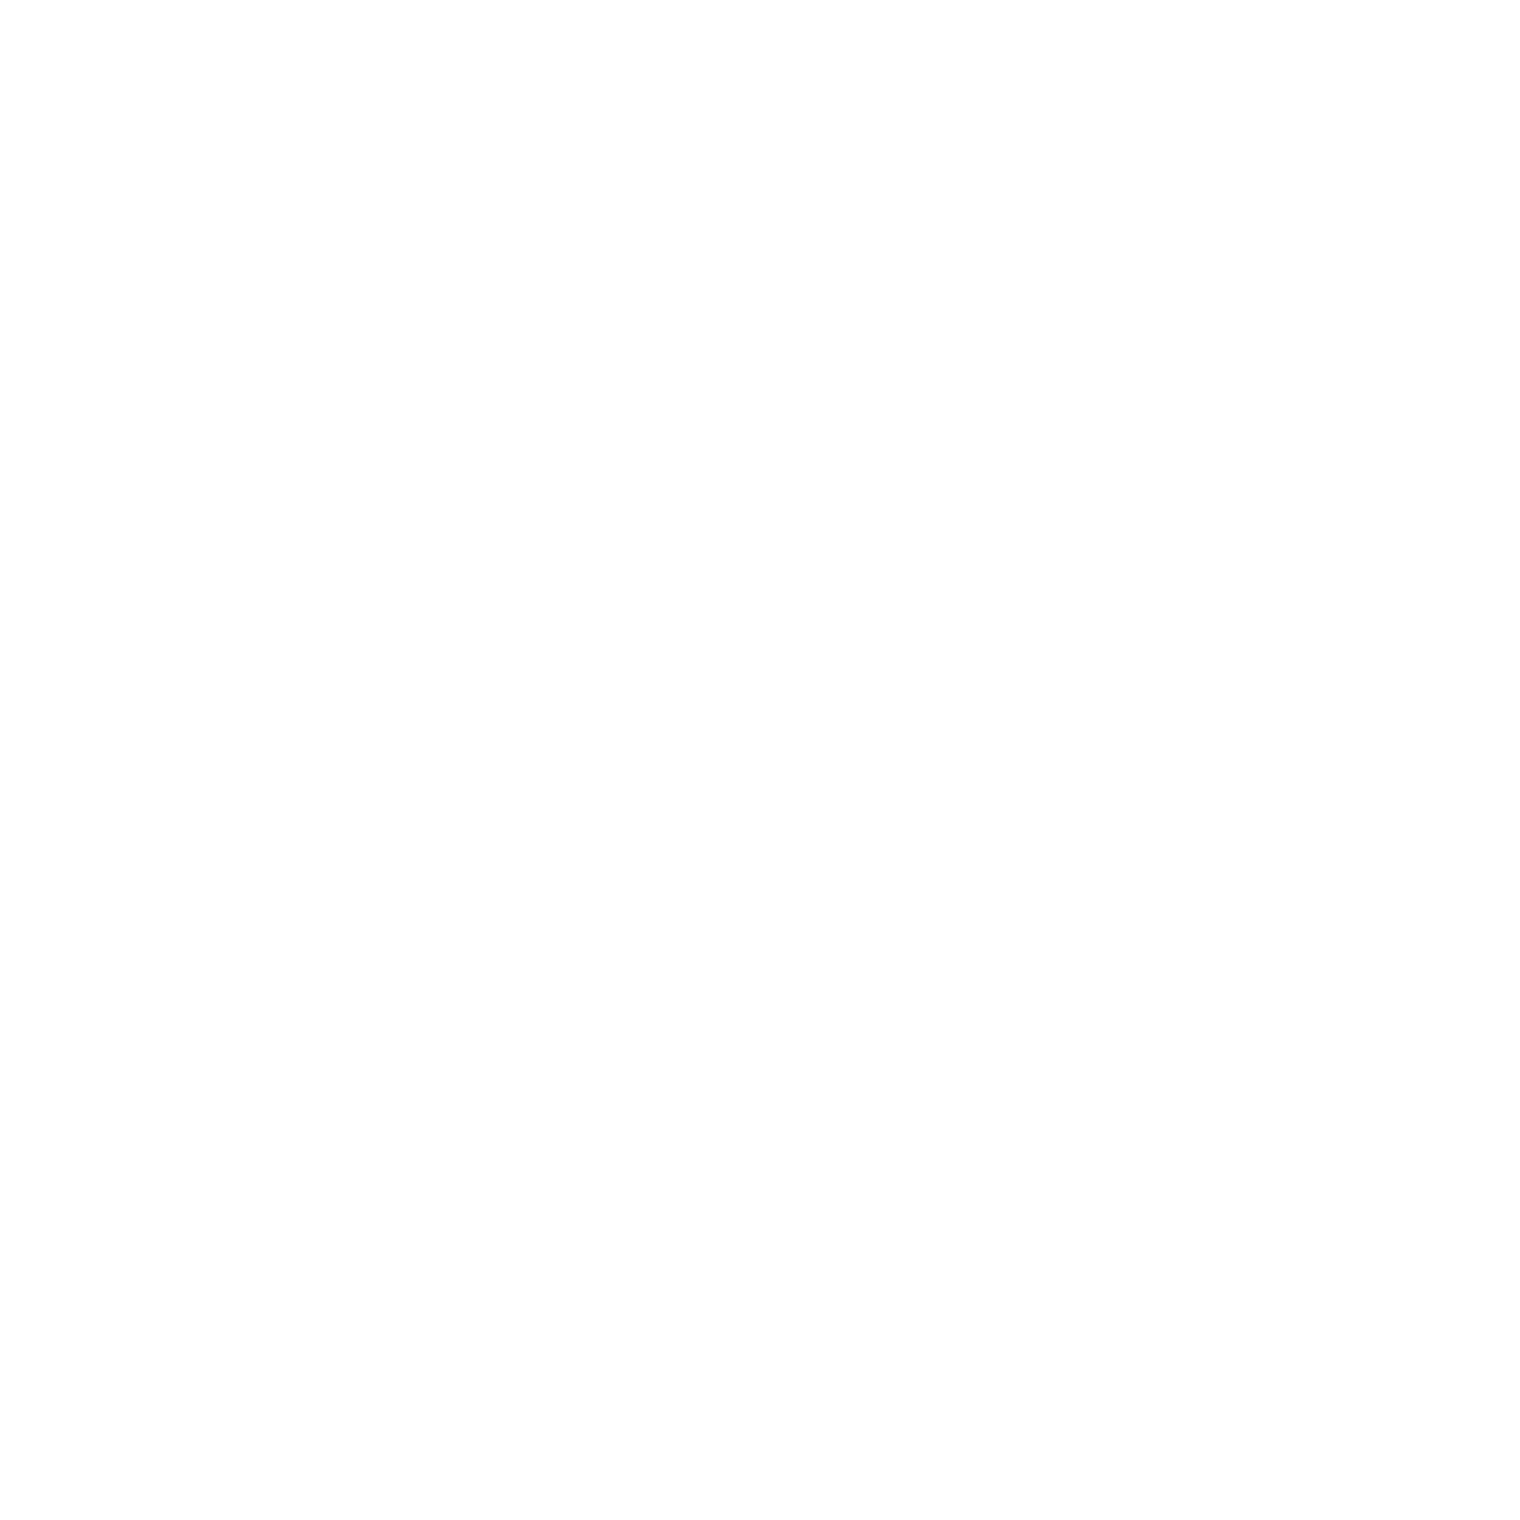

<IPython.core.display.Javascript object>


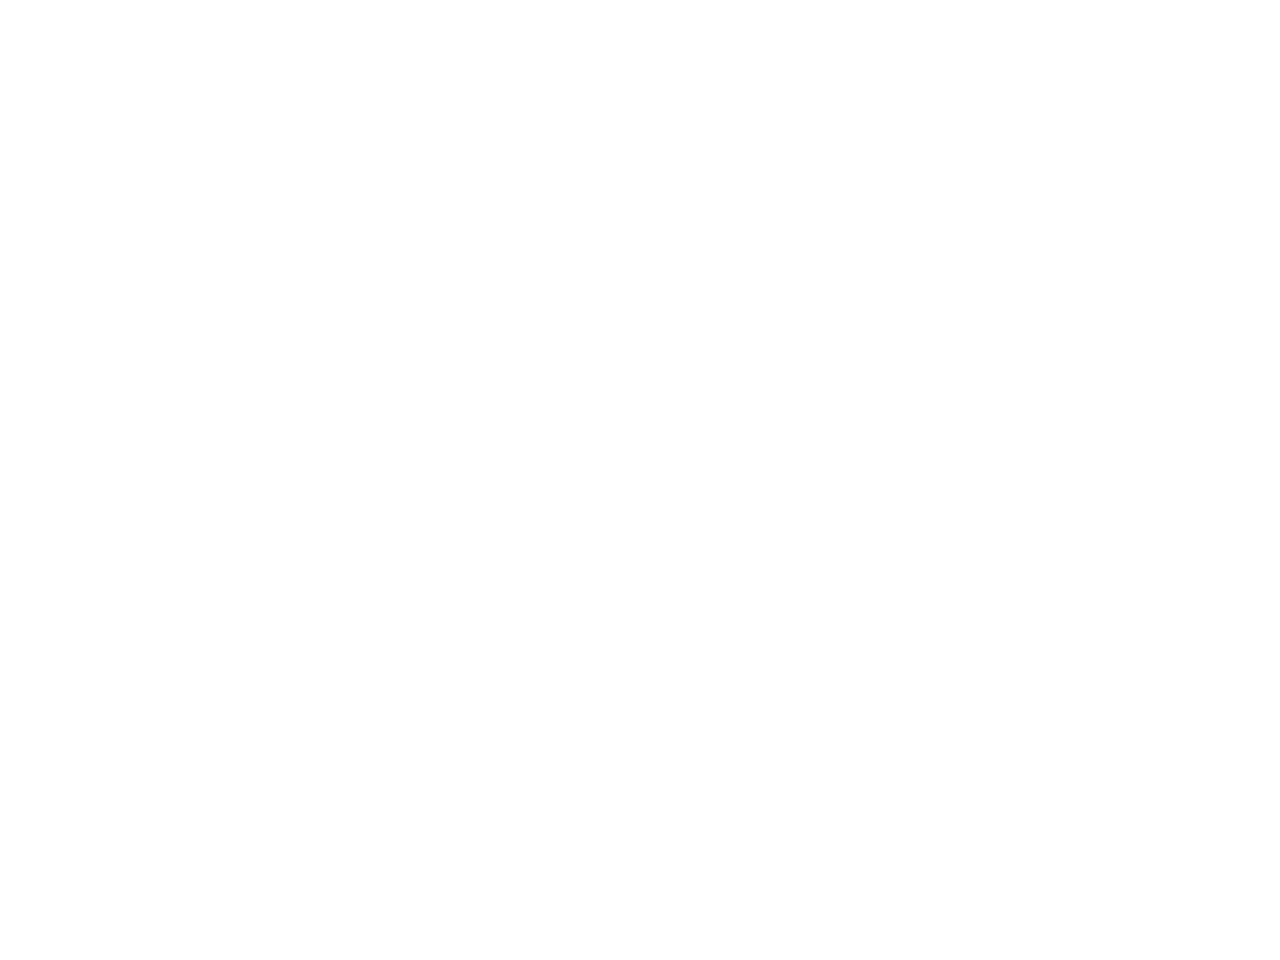

<IPython.core.display.Javascript object>


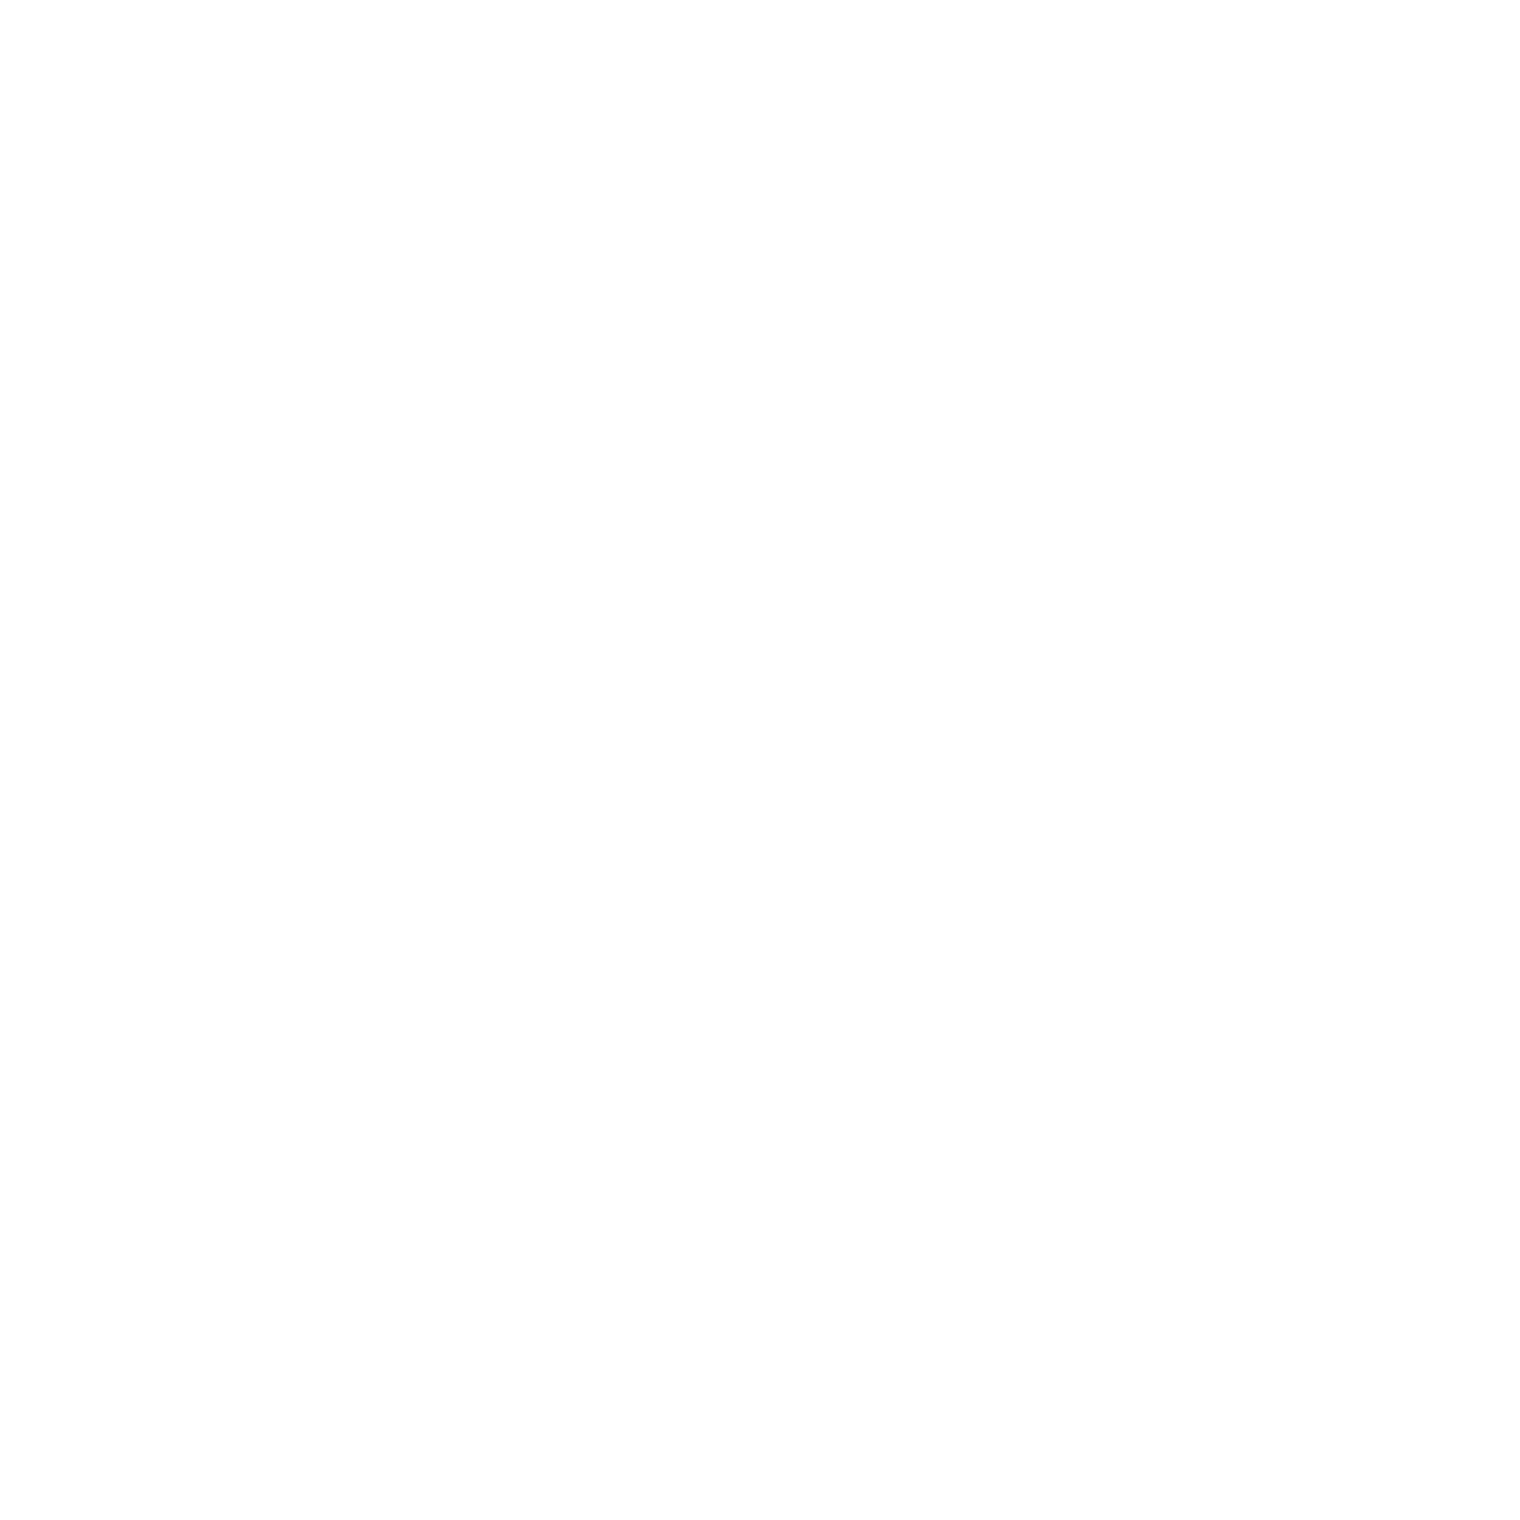

<IPython.core.display.Javascript object>


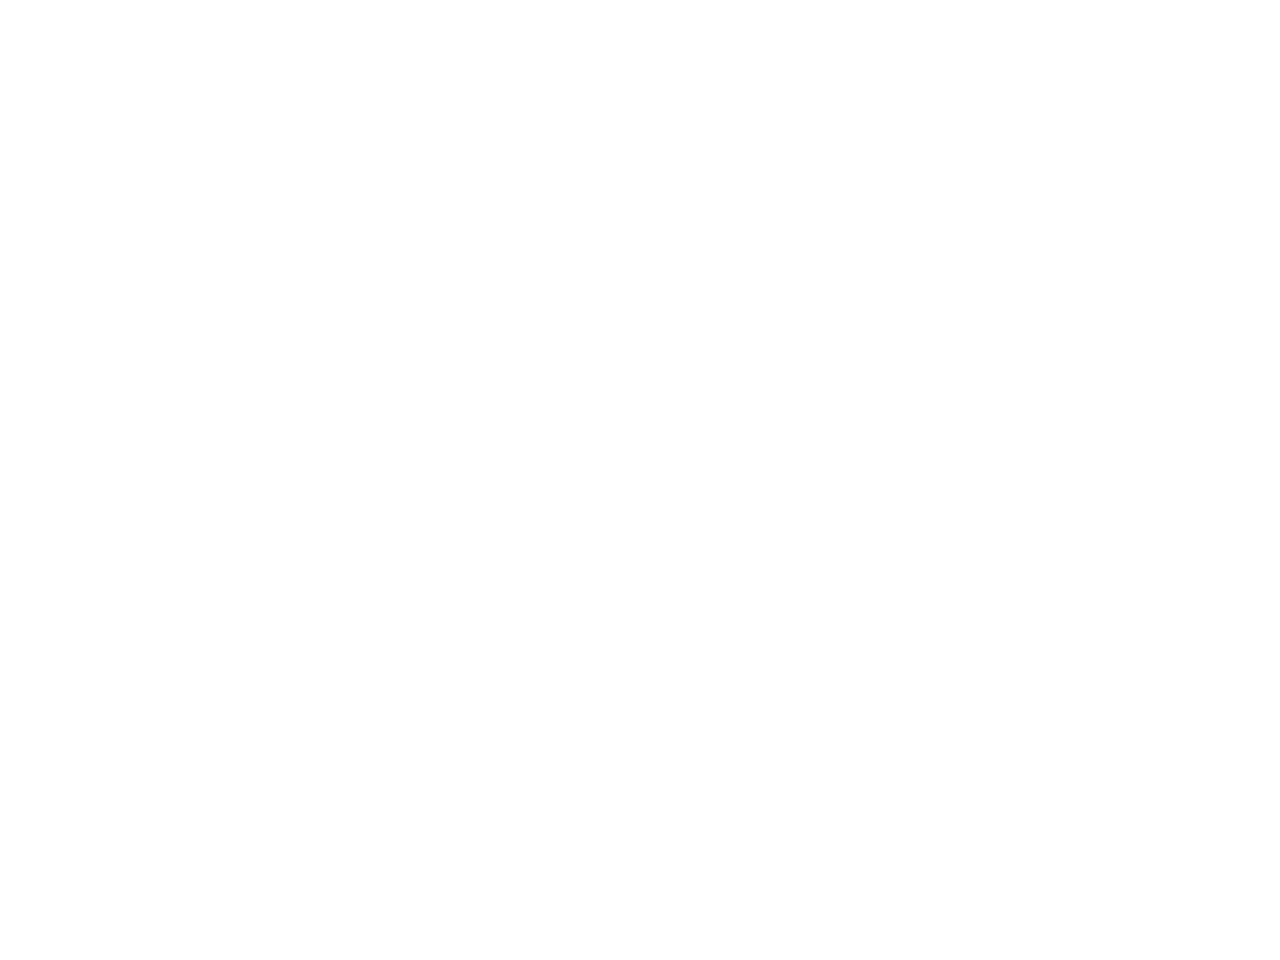

<IPython.core.display.Javascript object>


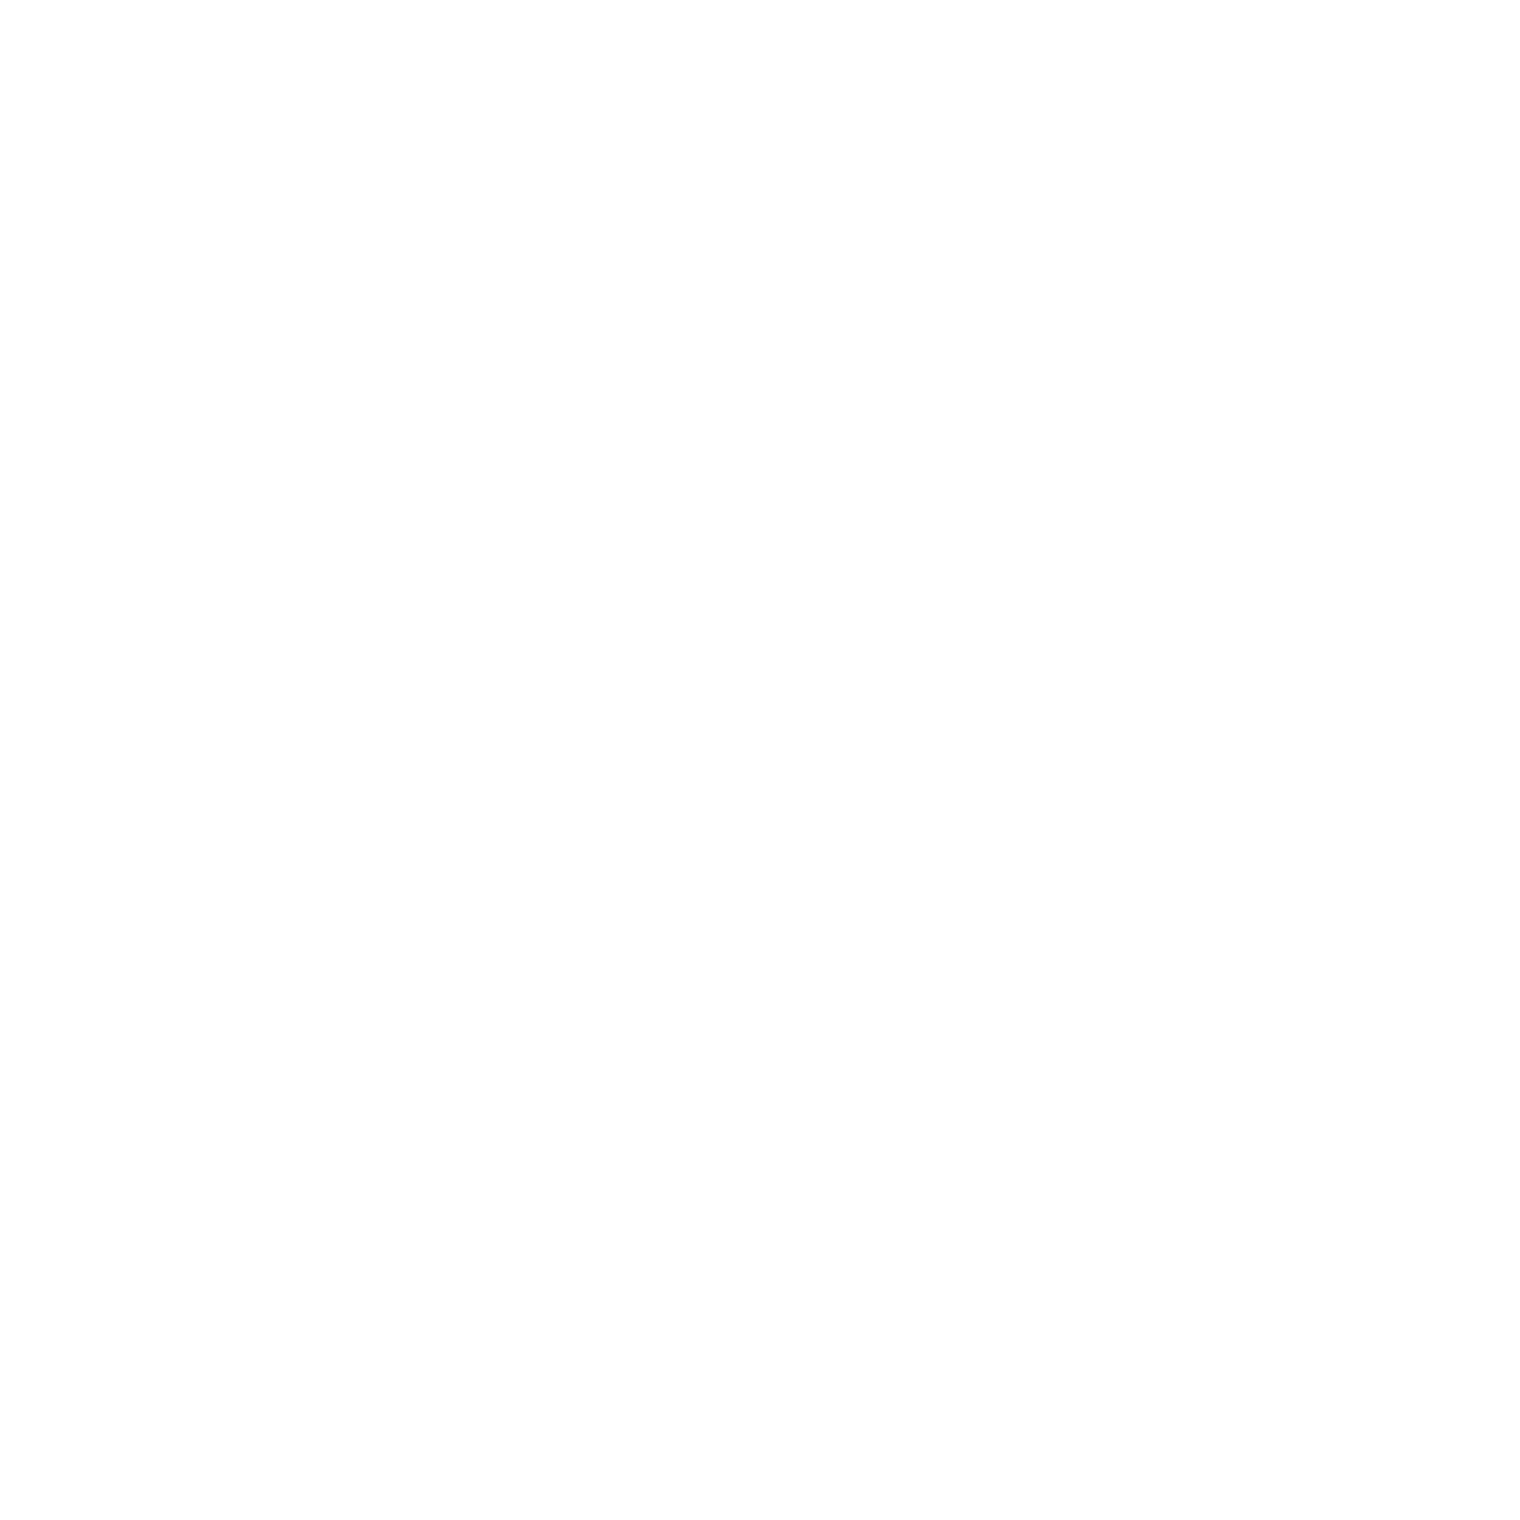

<IPython.core.display.Javascript object>


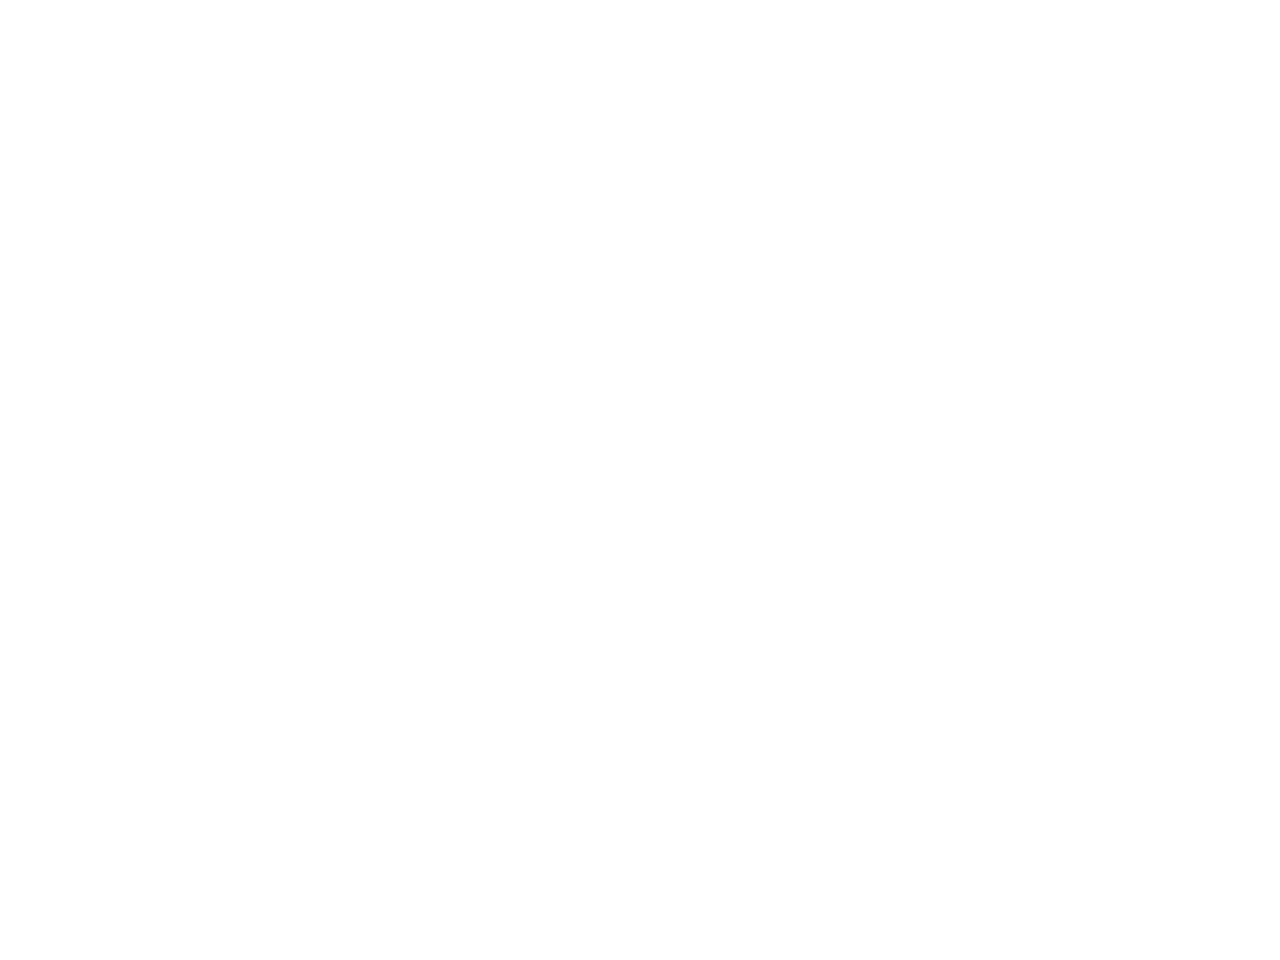

<IPython.core.display.Javascript object>


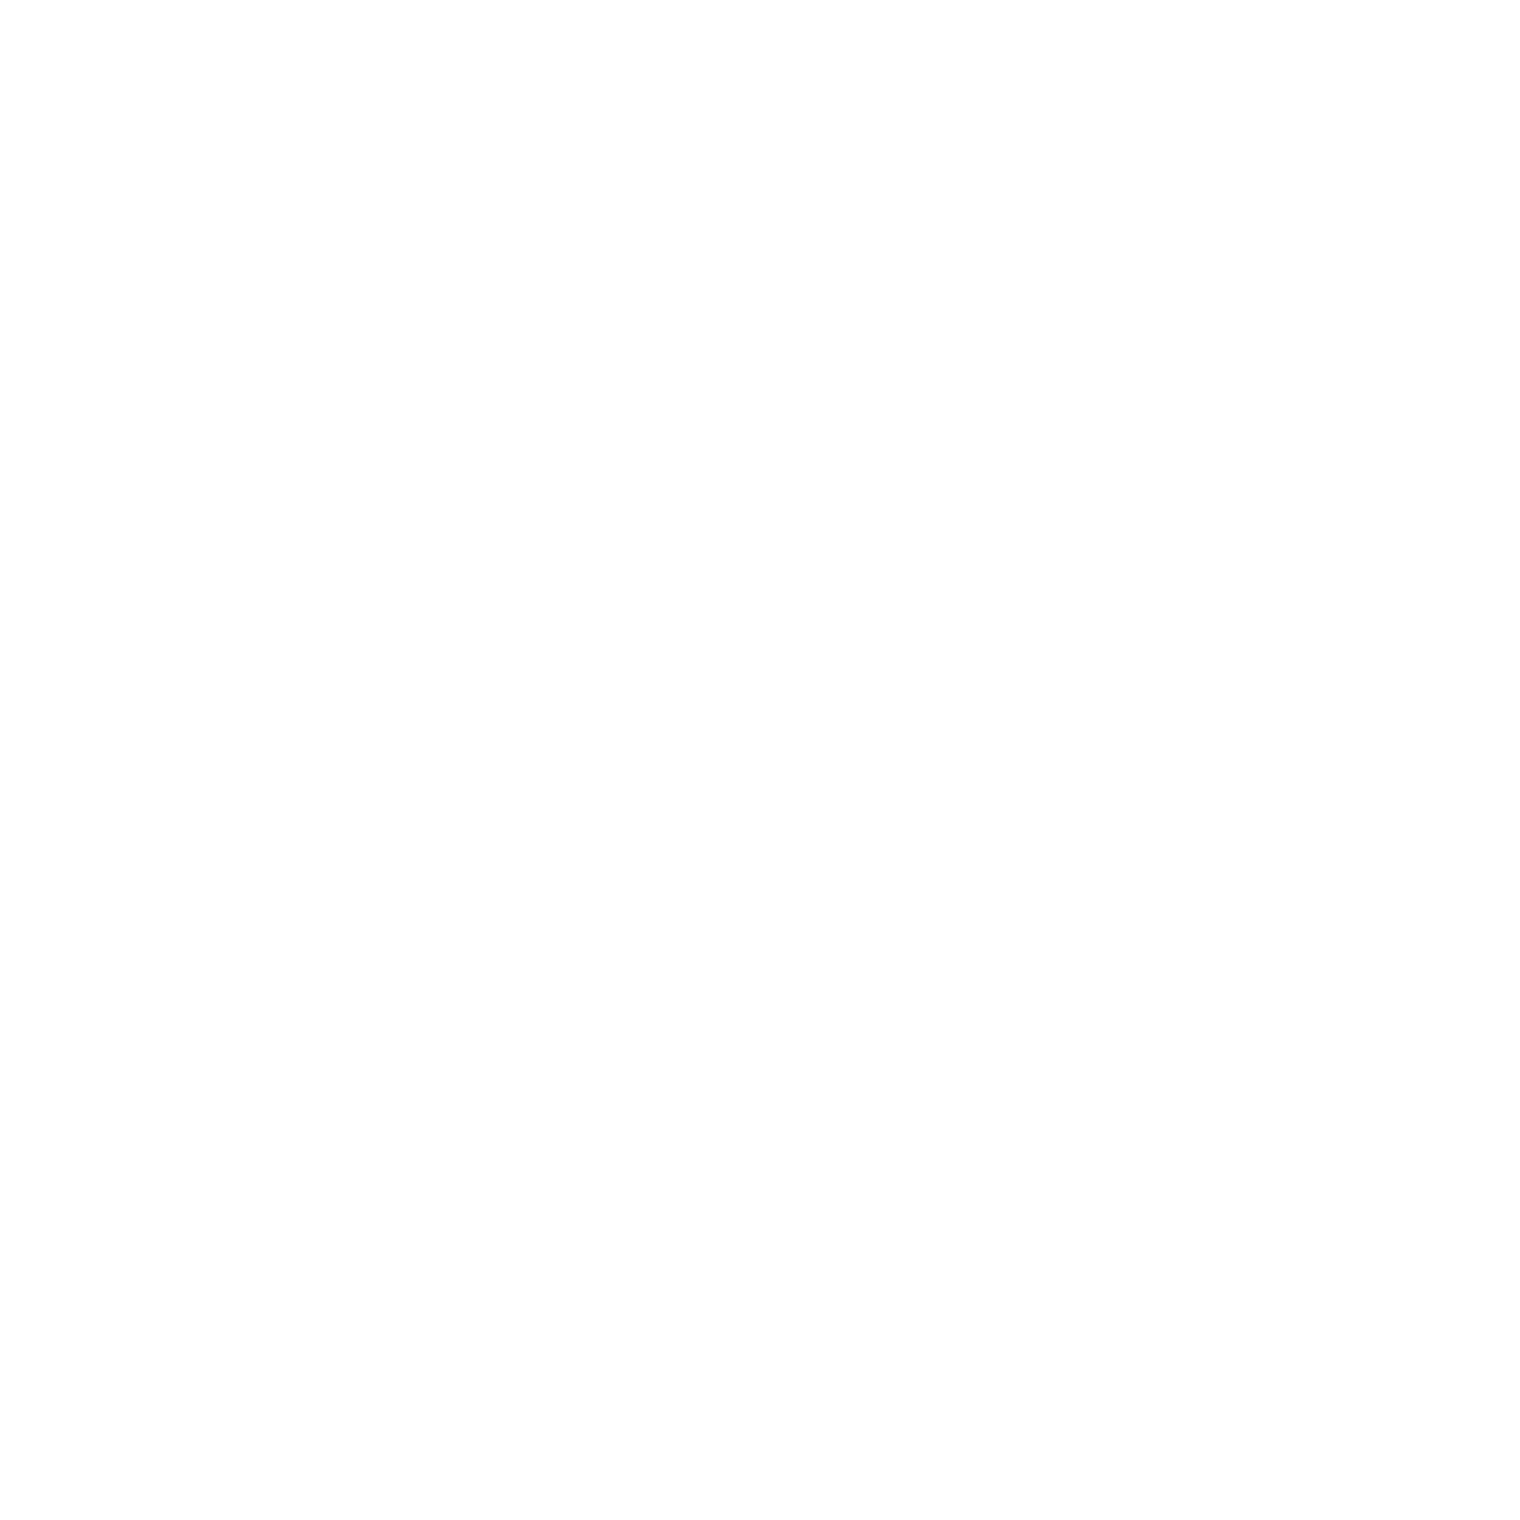

<IPython.core.display.Javascript object>


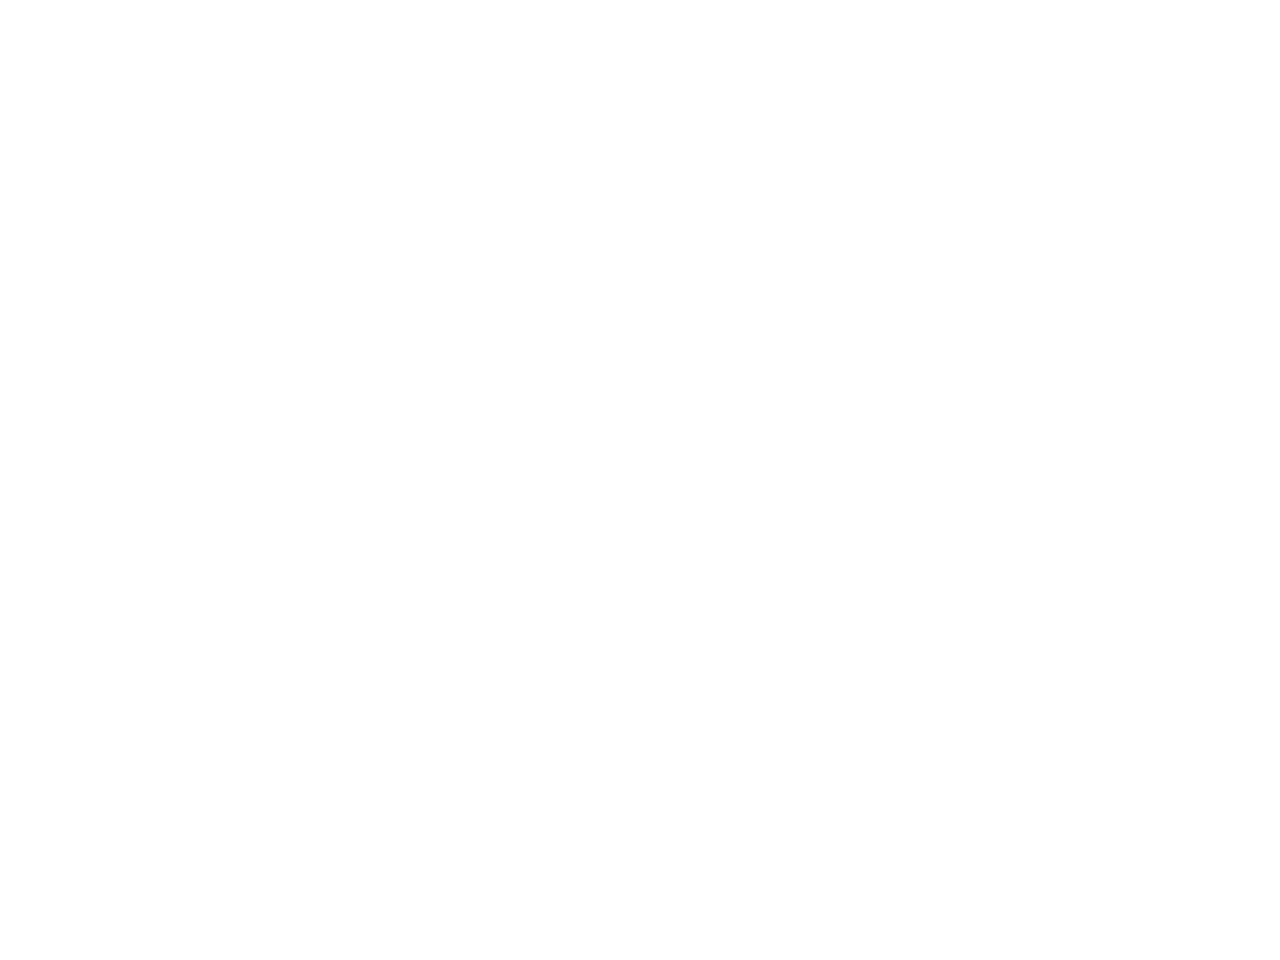

<IPython.core.display.Javascript object>


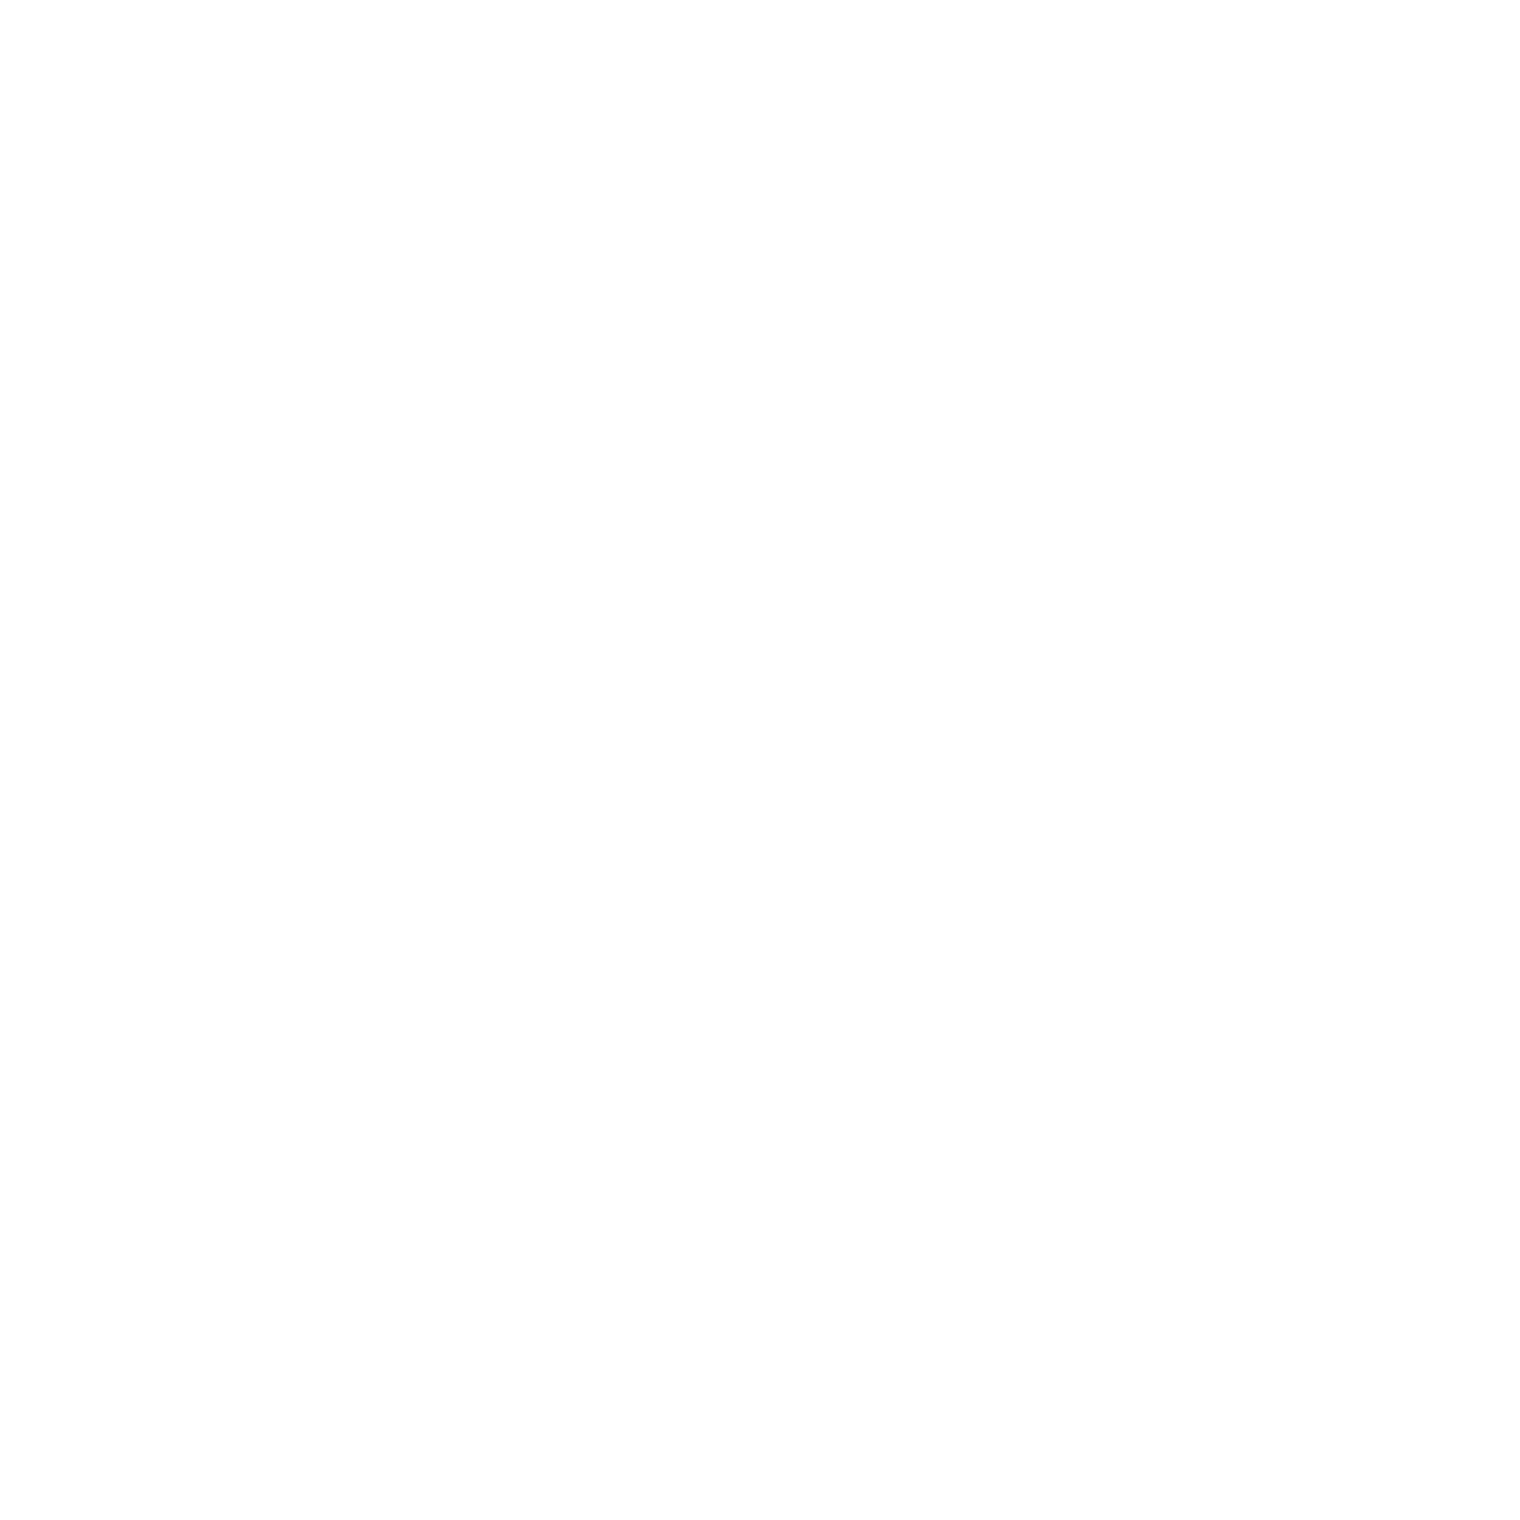

<IPython.core.display.Javascript object>


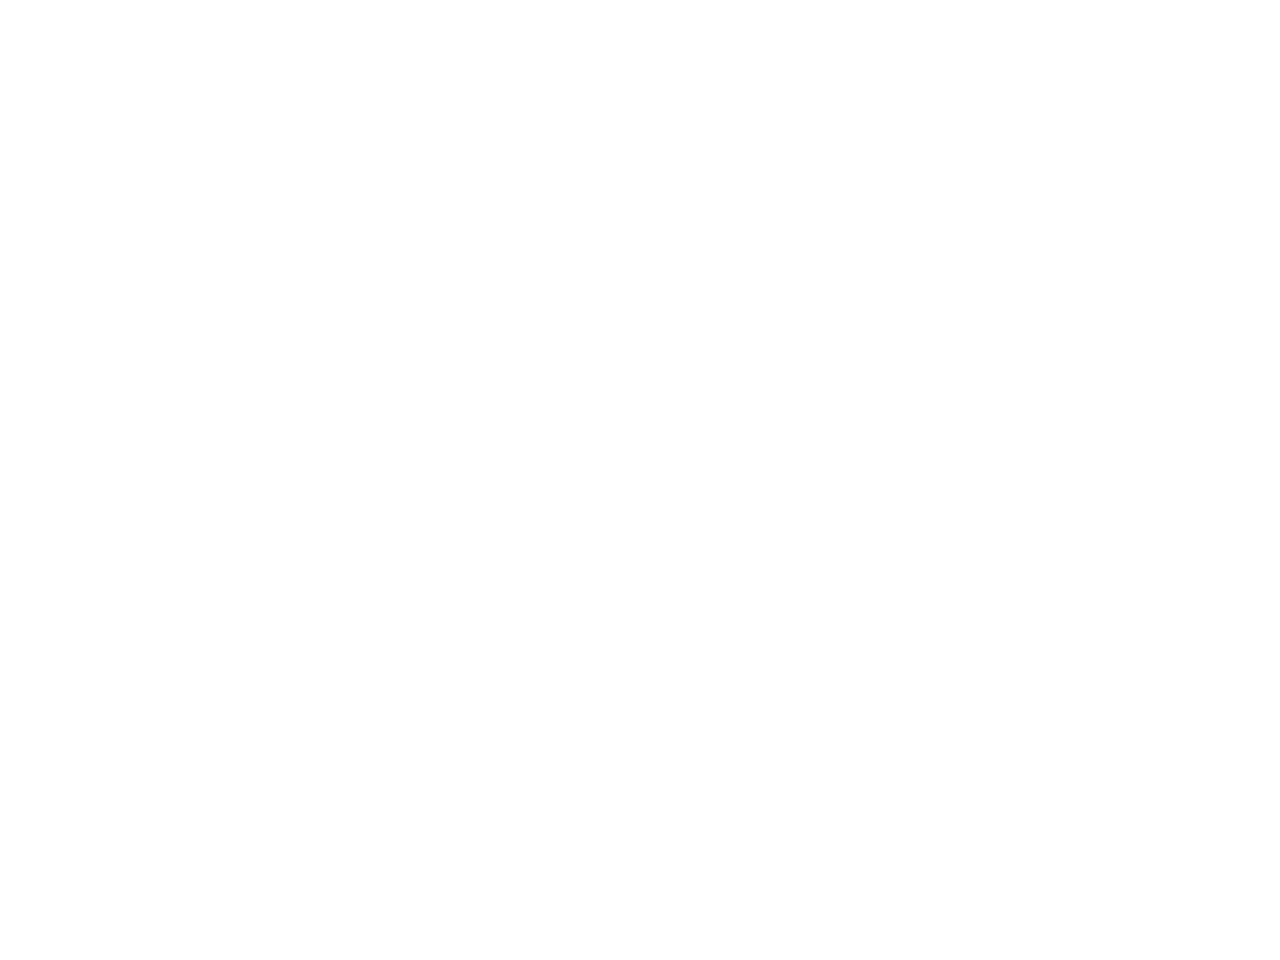

<IPython.core.display.Javascript object>


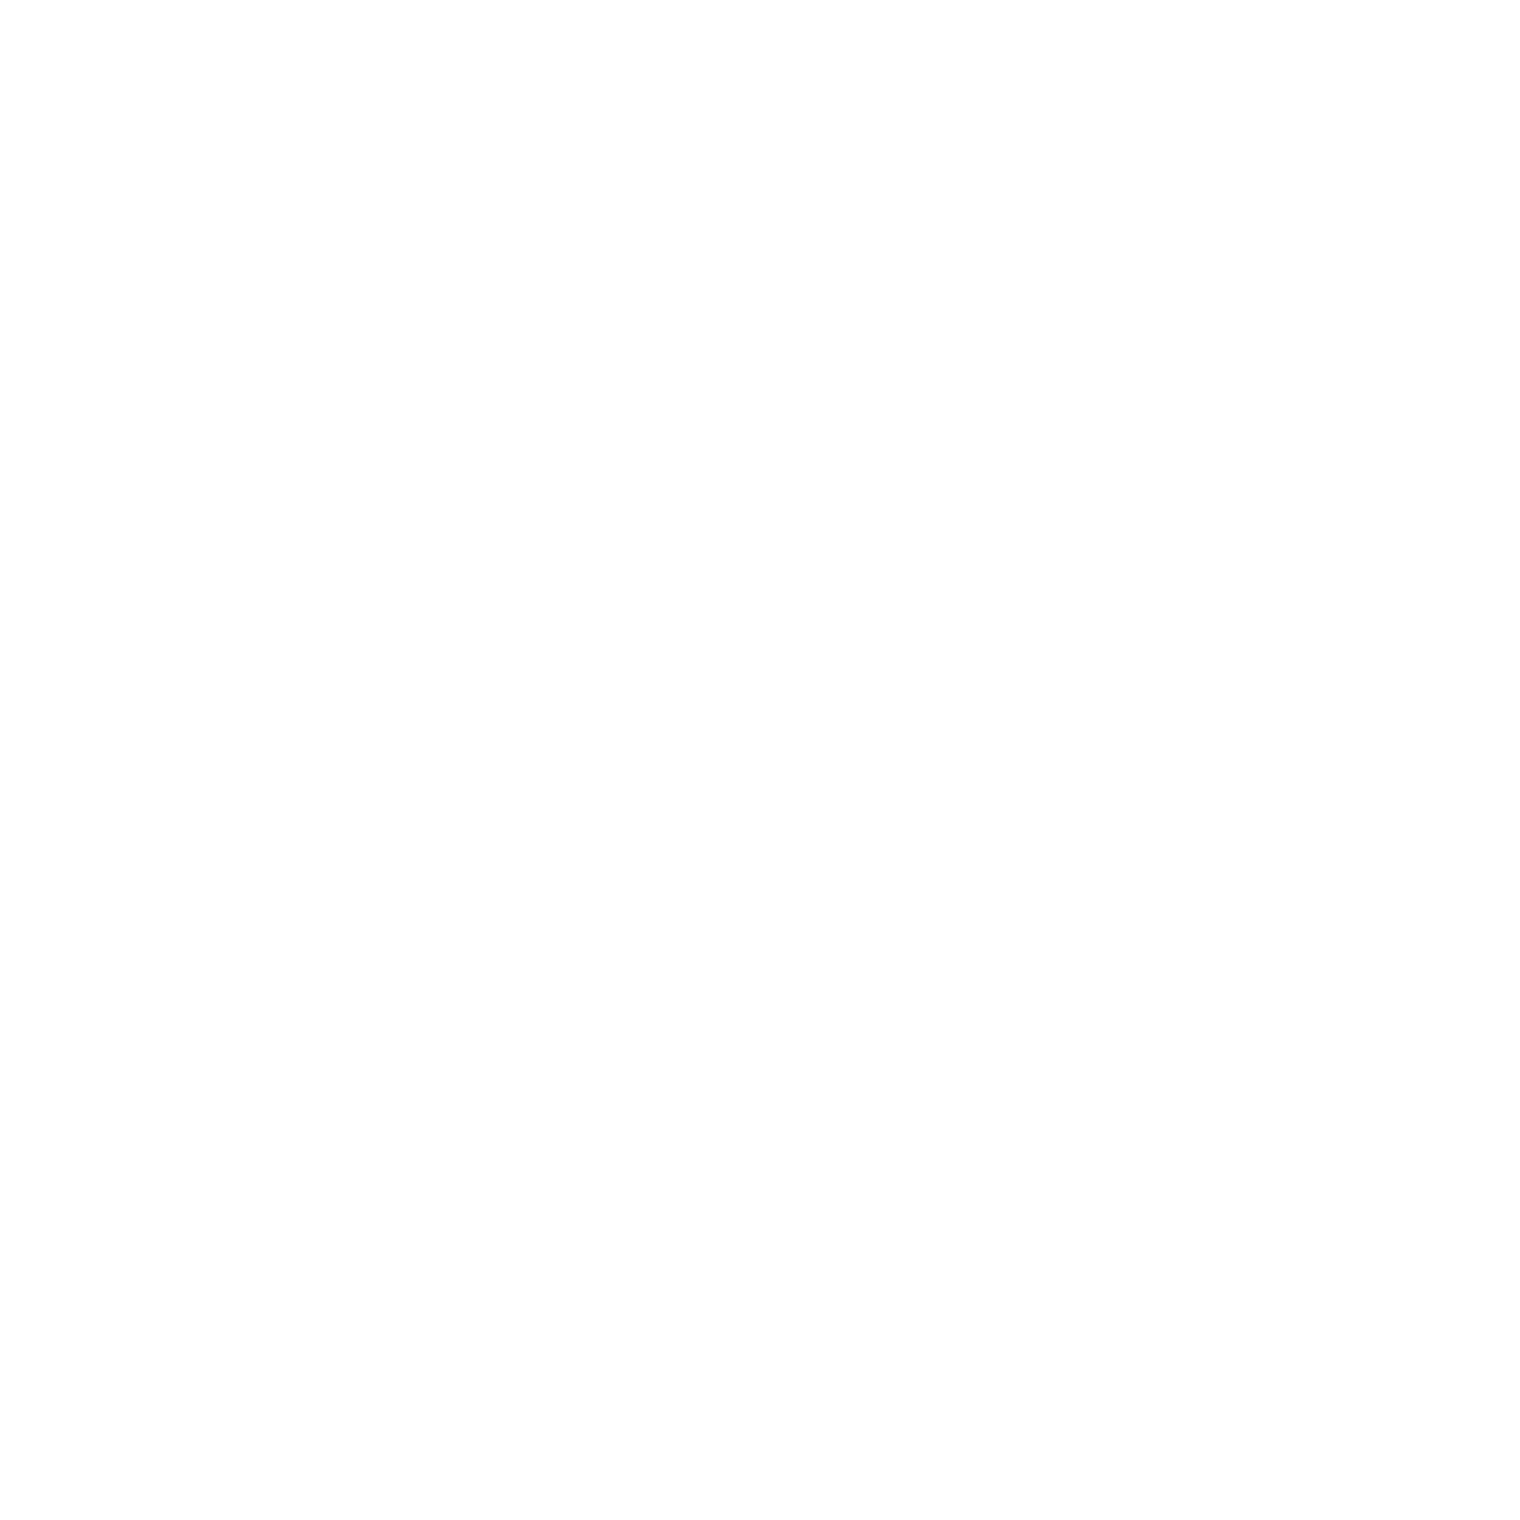

<IPython.core.display.Javascript object>


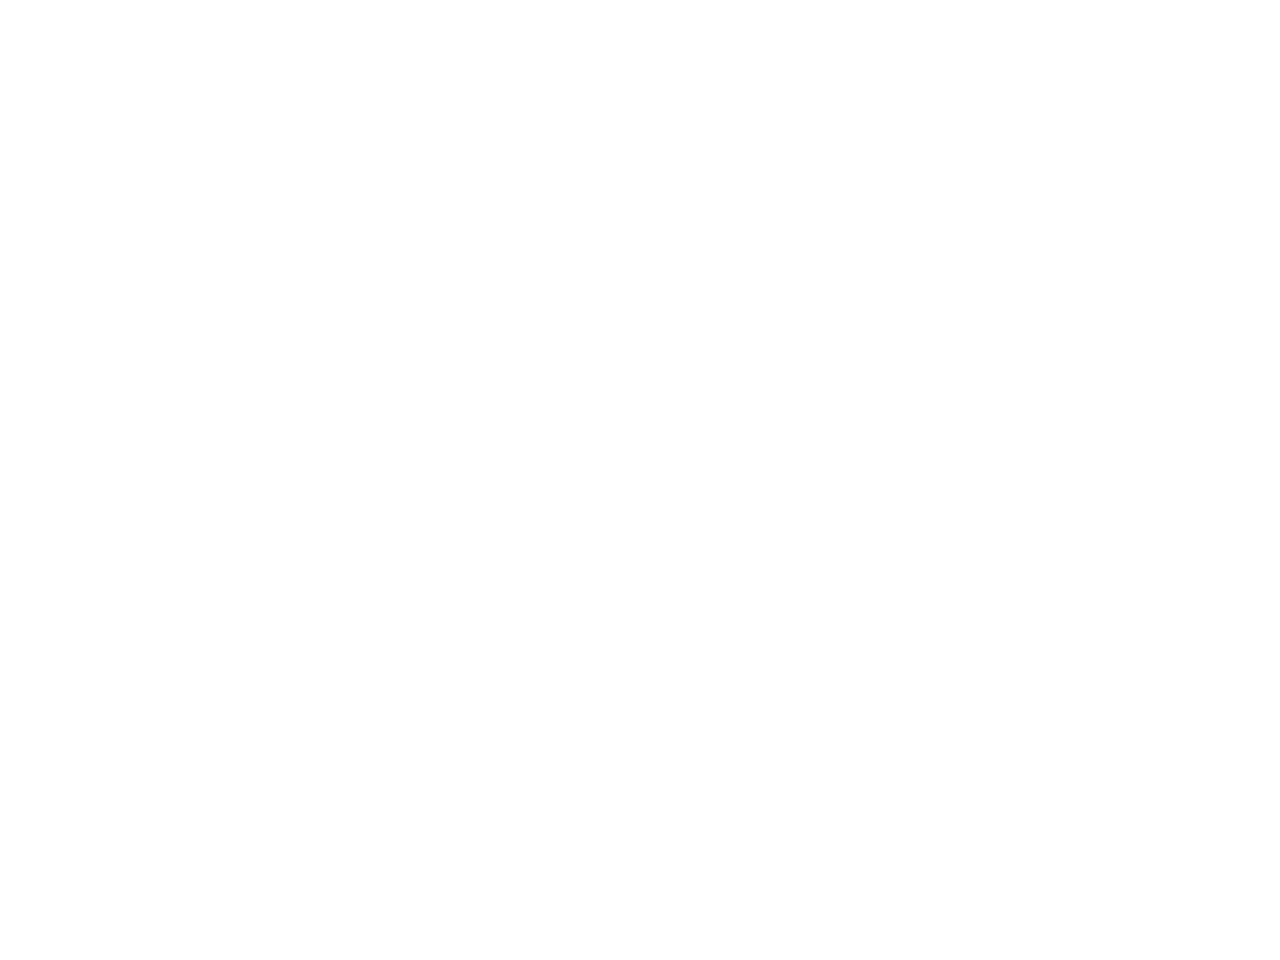

<IPython.core.display.Javascript object>


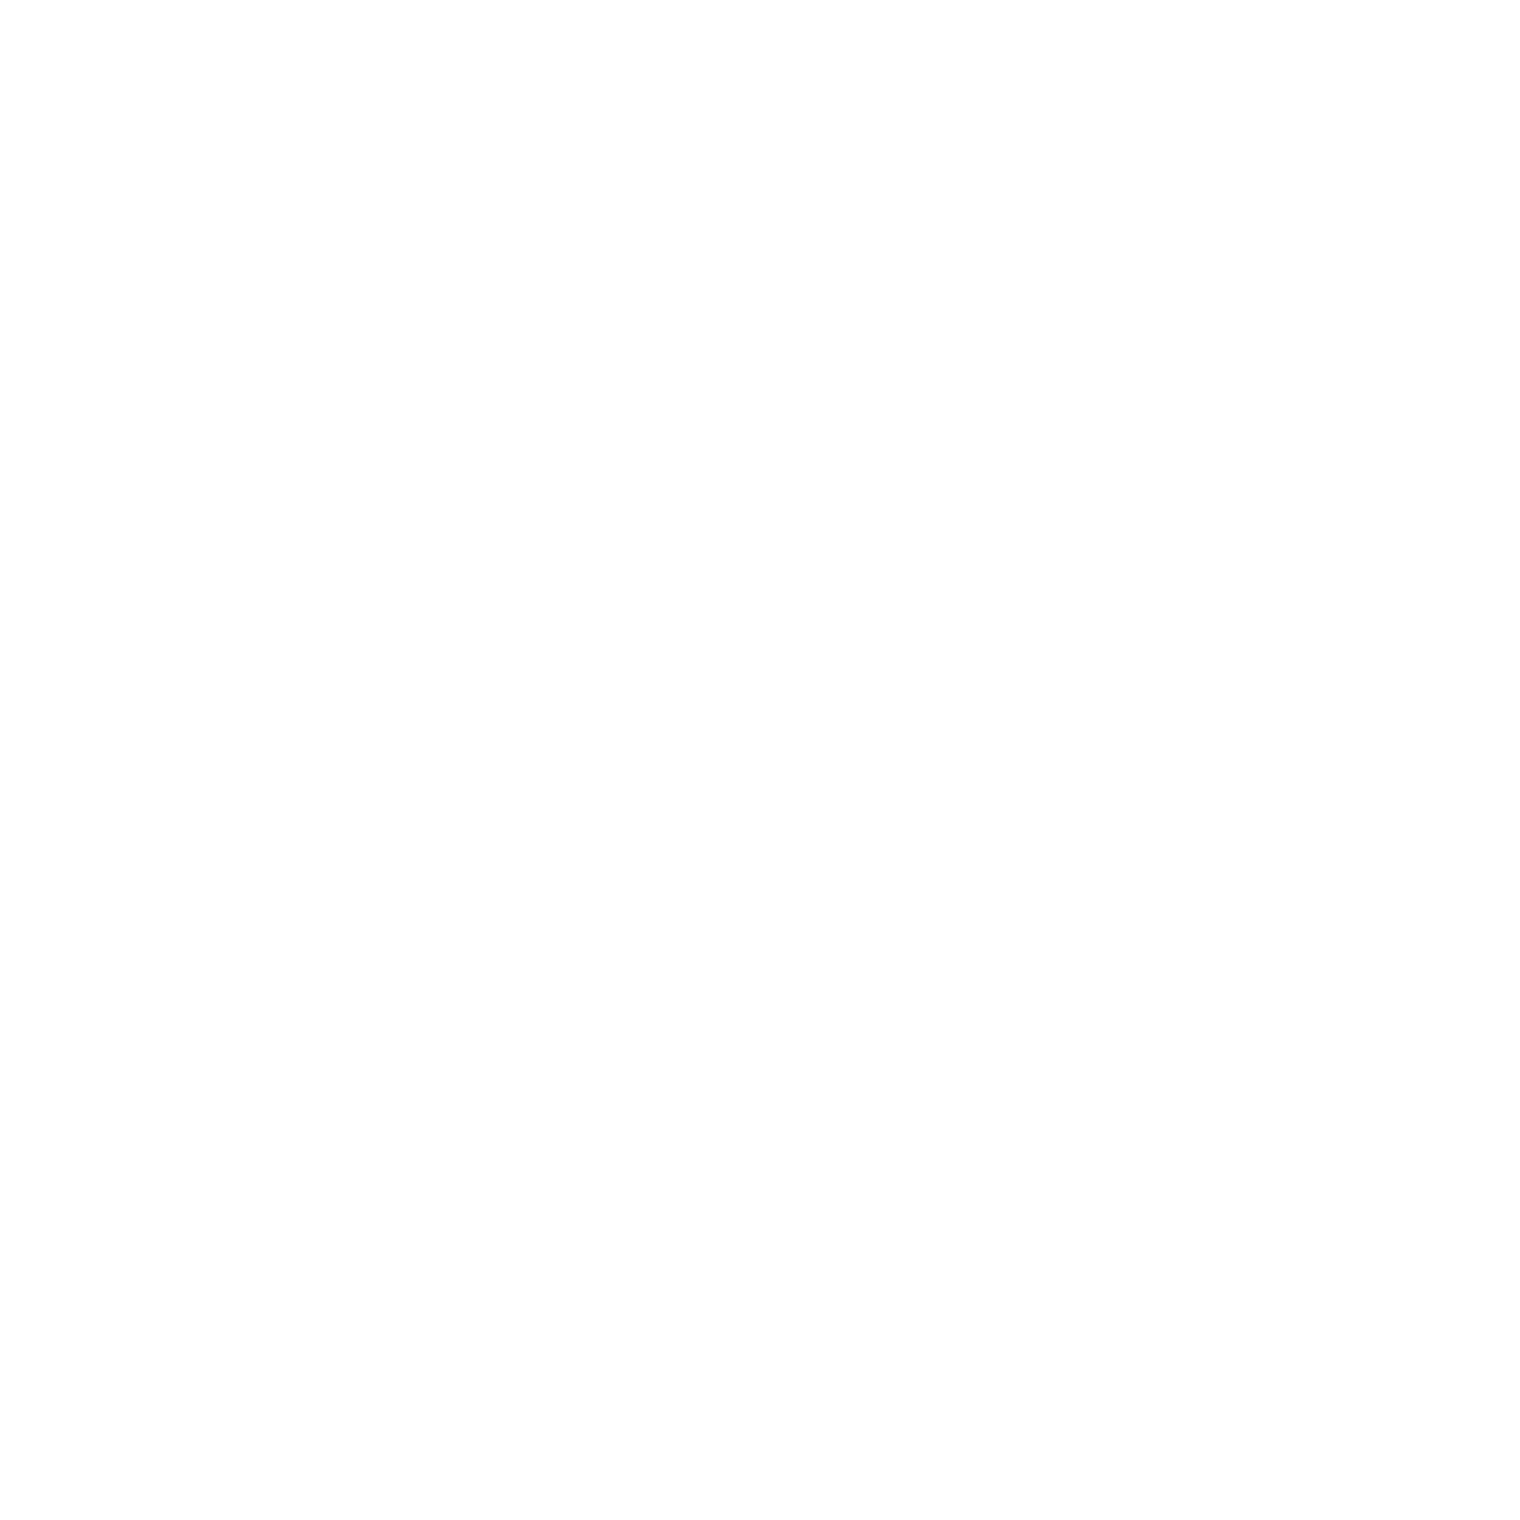

<IPython.core.display.Javascript object>


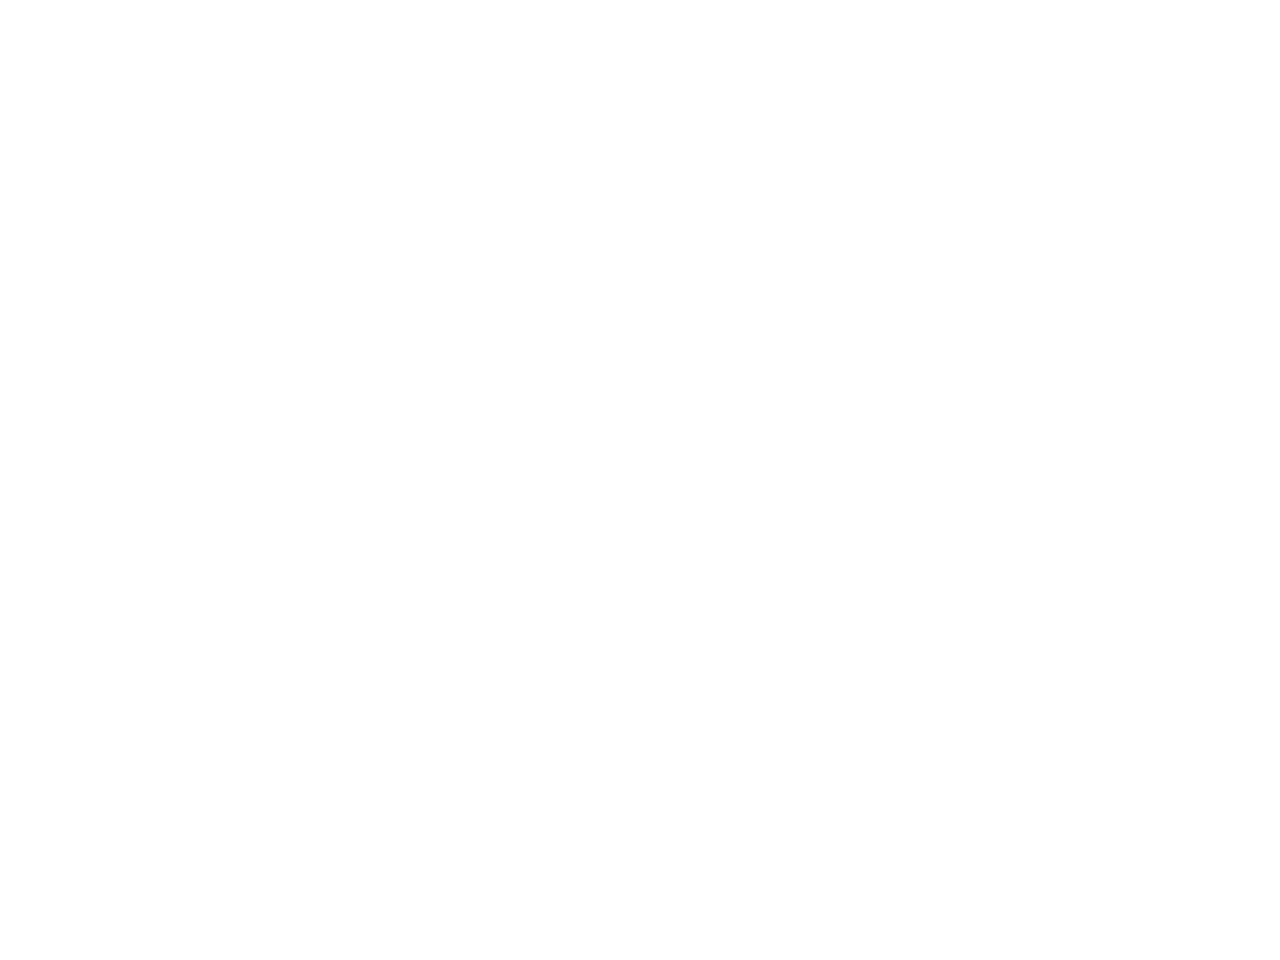

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [14]:
paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", 
             r"$A'_r$"]

for filenum, sn in enumerate(salt_df.name.values):
    h5_file = info_path + 'big_unc/{}_emcee_40_tsquared.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    if res_tsquared.conv_arr.iloc[filenum] > 0:
        burnin = int(5*np.max(tau))
        samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
        lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
        
        cfig = corner_hack(samples[:,0:3], labels=paramsNames,
                           show_titles=True, quantiles=[.05,.95], title_fmt=".4f",
                           plot_datapoints=True, plot_contours=True)
        cfig.savefig(info_path + 'big_unc/{}_corner_tsquared.png'.format(h5_file.split('/')[-1].split('_')[0]))

        t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
        z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
        g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
        r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

        t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                             t_max=t_max, 
                                                                             z=z,
                                                                             g_max=g_max,
                                                                             r_max=r_max,
                                                                             rel_flux_cutoff=rel_flux_cutoff, 
                                                                             return_masked=True)

        adjust_samp = np.zeros((np.shape(samples)[0],2+np.shape(samples)[1]))
        for alpha  in [2,4]:
            adjust_samp[:,alpha] = np.ones(len(samples))*2
        for param_num in range(len(samples[0])):
            if param_num < 2:
                adjust_samp[:,param_num]  = samples[:,param_num]
            elif param_num == 2:
                adjust_samp[:,param_num+1]  = samples[:,param_num]
            elif param_num > 2:
                adjust_samp[:,param_num+2]  = samples[:,param_num]


        max_posterior = adjust_samp[np.argmax(lnpost)]
        haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                              adjust_samp, np.random.choice(range(len(samples)), 8, replace=False))        
        haha.savefig(info_path + 'big_unc/{}_model_lc_tsquared.png'.format(sn))
        plt.close('all')

## Measure Rise Time for $t^2$ Law

In [6]:
res_tsquared = pd.read_csv('results_40_tsquared.csv')

In [7]:
bw_df = pd.read_csv('kde_bandwidths_delta2.csv')

In [8]:
pdf_array_tfl = np.zeros((len(res_tsquared), 100000))
prop_unc_arr = np.zeros((len(res_tsquared), 100000))

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_tsquared.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    t_max_unc = salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0] # SALT B for normal SNe, g poly for others

    t_grid = np.linspace(-25,-5,100000)
    
    if t_max_unc == salt_df.t0_salt2_unc.iloc[np.where(salt_df.name == sn)].values[0]:
        # correct to B band max from g_ztf max
        t_B_max = salt_df.t0_B_salt2.iloc[np.where(salt_df.name == sn)].values[0]
        t_g_max = salt_df.t0_g_adopted.iloc[np.where(salt_df.name == sn)].values[0]
        z_sn = salt_df.z_adopt.iloc[np.where(salt_df.name == sn)].values[0]

        t_fl_samples = samples[:,0] + (t_g_max - t_B_max)/(1 + z_sn)
    else:
        print(sn)
        t_fl_samples = samples[:,0]
    t_fl_data = np.reshape(t_fl_samples, (len(t_fl_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(t_fl_data)

    pdf = kde.score_samples(t_grid.reshape(100000,1))
    
    prop_unc = gaussian_filter1d(np.exp(pdf), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

    pdf_array_tfl[sn_num] = pdf
    prop_unc_arr[sn_num] = prop_unc
    
    return (pdf, prop_unc)

pool = Pool()

t_fl_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.tfl_bw.values))

ZTF18aawpcel
ZTF18aaykjei
ZTF18abclfee
ZTF18abdpvnd
ZTF18abddmrf
ZTF18abhpgje


In [9]:
t_grid = np.linspace(-30,-5,100000)

pdf_array_tfl = np.array(t_fl_res)[:,0]
prop_unc_arr = np.array(t_fl_res)[:,1]

norm_likelihood = np.sum(prop_unc_arr, axis=1)/len(t_grid)*np.ptp(t_grid)
norm_pdf_array = np.log(prop_unc_arr) - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(t_grid), axis=1)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [10]:
mean_fl = np.sum(norm_pdf_array, axis=0)

norm_mean = np.sum(np.exp(mean_fl - np.max(mean_fl)))/len(t_grid)*np.ptp(t_grid)
mean_pdf_tfl = mean_fl - np.max(mean_fl) - np.repeat(np.log(norm_mean), len(t_grid))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


In [11]:
normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != 'SC*') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res_tsquared.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)

# rearange for plotting
normal_plot = np.setdiff1d(normal[0], normal_good)
normal_good_plot = np.setdiff1d(normal_good, normal_good_host)

In [12]:
# plotting dictionary
color_dict = {'orange': '#F0810F',
              'blueberry': '#063852',
              'dark navy': '#011A27'}

<IPython.core.display.Javascript object>


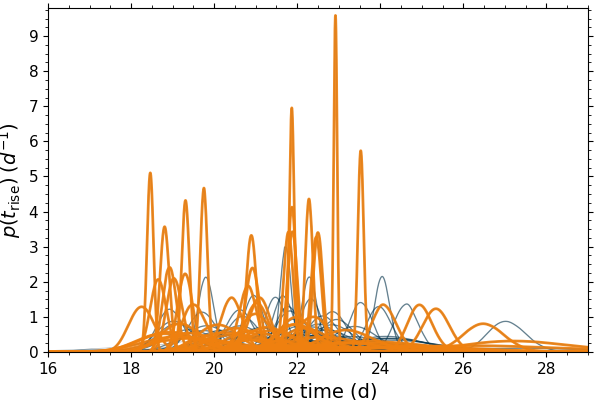

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['orange'], lw=2, alpha=0.9)
    

ax.set_xlim(16,29)
ax.set_ylim(0,9.8)
ax.set_xlabel('rise time (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.12,top=0.98,right=0.98)
fig.savefig('../paper/figures/tsquared_rise_time.pdf')

<IPython.core.display.Javascript object>


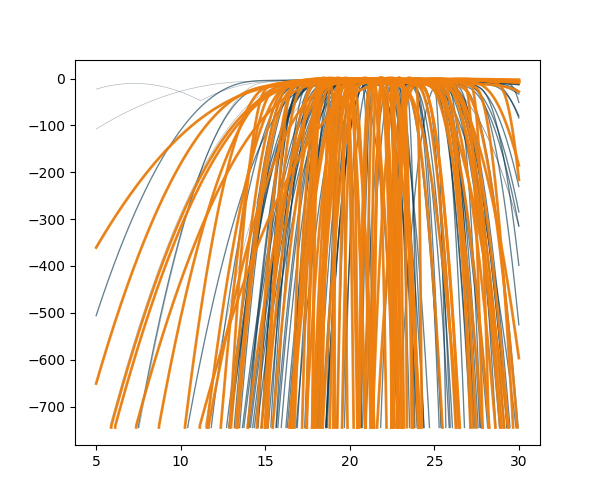

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['orange'], lw=2, alpha=0.9)


<IPython.core.display.Javascript object>


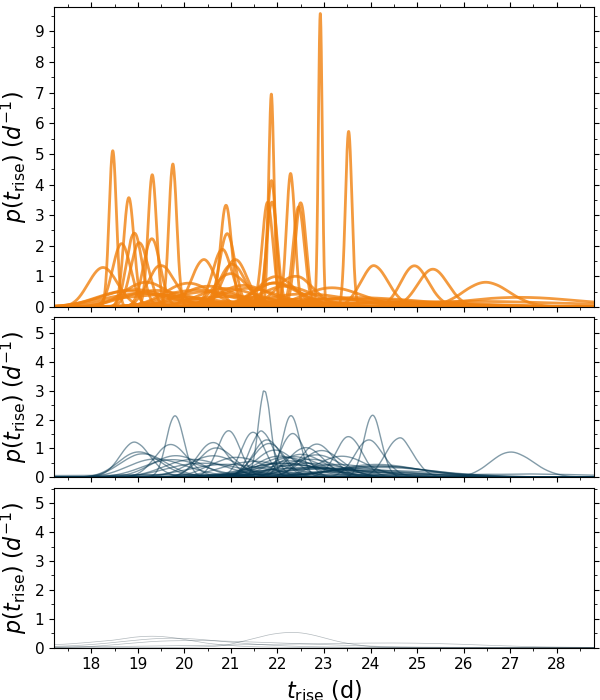

In [18]:
talk_plot = False
if talk_plot:
    figsize = (9,9)
else:
    figsize = (6,7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=figsize, sharex=True, 
                                    gridspec_kw={'width_ratios': [1],
                                                 'height_ratios':[3,1.6,1.6]})



for pdf_tfl in norm_pdf_array[normal_plot]:
    ax3.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good_plot]:
    ax2.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax1.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['orange'], lw=2, alpha=0.8)

ax1.set_ylim(0,9.8)
ax2.set_ylim(0,9.8*1.7/3)
ax3.set_ylim(0,9.8*1.7/3)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(2))


ax.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)


if talk_plot:
    ax1.set_xlim(12,23)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=17)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=17)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=13)
        ax.vlines(2.0, -10, 10, colors='0.4', linestyles='--')
    
    fig.subplots_adjust(left=0.065,bottom=0.065,top=0.99,right=0.99,hspace=0.05)
else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=16)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=11)

    ax1.set_xlim(17.2,28.8)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=16)

    fig.subplots_adjust(left=0.09,bottom=0.075,top=0.99,right=0.99,hspace=0.05)
    fig.savefig('../paper/figures/tsquared_rise_time.pdf')

### Get Rise Time Uncertainties

In [19]:
t_rise_05 = np.zeros(len(res_tsquared))
t_rise_16 = np.zeros_like(t_rise_05)
t_rise_50 = np.zeros_like(t_rise_05)
t_rise_84 = np.zeros_like(t_rise_05)
t_rise_95 = np.zeros_like(t_rise_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(t_grid)*np.ptp(t_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    t_rise_95[sn_num] = -1*np.interp(0.05, cum_prob[idx_05-1:idx_05+1], t_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    t_rise_84[sn_num] = -1*np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], t_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    t_rise_50[sn_num] = -1*np.interp(0.50, cum_prob[idx_50-1:idx_50+1], t_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    t_rise_16[sn_num] = -1*np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], t_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    t_rise_05[sn_num] = -1*np.interp(0.95, cum_prob[idx_95-1:idx_95+1], t_grid[idx_95-1:idx_95+1])

In [37]:
# weighted mean
np.average(t_rise_50, weights=((t_rise_84-t_rise_16)/2)**(-2))

20.997993110928377

In [47]:
np.mean(t_rise_50), np.median(t_rise_50)

(21.148083834280712, 21.22474969005197)

In [40]:
np.std(t_rise_50, ddof=1)

2.180519683110574

In [49]:
1.4826*np.median(np.abs(t_rise_50 - np.median(t_rise_50)))

1.808165355436515

In [20]:
res_tsquared['t_rise_05'] = t_rise_05
res_tsquared['t_rise_16'] = t_rise_16
res_tsquared['t_rise_50'] = t_rise_50
res_tsquared['t_rise_84'] = t_rise_84
res_tsquared['t_rise_95'] = t_rise_95

res_tsquared.to_csv('results_40_tsquared.csv', index=False)

In [21]:
# read in the results
res_tsquared = pd.read_csv('results_40_tsquared.csv')

t_rise_50 = res_tsquared.t_rise_50.values
t_rise_16 = res_tsquared.t_rise_16.values
t_rise_84 = res_tsquared.t_rise_84.values

sigma_i = (t_rise_84-t_rise_16)/2
w_i = (sigma_i)**(-2)

normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != 'SC*') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res_tsquared.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)

# rearange for plotting
normal_plot = np.setdiff1d(normal[0], normal_good)
normal_good_plot = np.setdiff1d(normal_good, normal_good_host)

color_dict = {'orange': '#F0810F',
              'blueberry': '#063852',
              'dark navy': '#011A27'}

print('there are {} normal SNe in sample'.format(len(normal[0])))
print('there are {} normal-reliable SNe in sample'.format(len(normal_good)))
print('there are {} normal-reliable-zhost SNe in sample'.format(len(normal_good_host)))

there are 120 normal SNe in sample
there are 115 normal-reliable SNe in sample
there are 58 normal-reliable-zhost SNe in sample


In [24]:
print('The following are summary statistics for rise time:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal]), np.median(t_rise_50[normal]),
                                                                   np.average(t_rise_50[normal], 
                                                                              weights=w_i[normal])))
print('std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal], ddof=1), 
                                                       1.4826*np.median(np.abs(t_rise_50[normal] - np.median(t_rise_50[normal]))),
                                                       1/np.sum(w_i[normal])*np.sqrt(np.sum((w_i[normal]*sigma_i[normal])**2))))

salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal], t_rise_50[normal], 
                            salt_df.x1_salt2_unc.values[normal], sigma_i[normal])
salt_uninformative.mle_slope_intercept(slope_guess=1.5, intercept_guess=19)
print('the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal])
print('the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))
print(' ')
print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good]), np.median(t_rise_50[normal_good]),
                                                                   np.average(t_rise_50[normal_good], 
                                                                              weights=w_i[normal_good])))
print('    std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good], ddof=1), 
                                                                   1.4826*np.median(np.abs(t_rise_50[normal_good] - np.median(t_rise_50[normal_good]))), 
                                                                   1/np.sum(w_i[normal_good])*np.sqrt(np.sum((w_i[normal_good]*sigma_i[normal_good])**2))))
salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal_good], t_rise_50[normal_good], 
                            salt_df.x1_salt2_unc.values[normal_good], sigma_i[normal_good])
salt_uninformative.mle_slope_intercept(slope_guess=1.5, intercept_guess=21)
print('    the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('    the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal_good] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal_good])
print('    the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))
print(' ')
print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good_host]), np.median(t_rise_50[normal_good_host]),
                                                                   np.average(t_rise_50[normal_good_host], 
                                                                              weights=w_i[normal_good_host])))
print('\t  std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good_host], ddof=1), 
                                                                   1.4826*np.median(np.abs(t_rise_50[normal_good_host] - np.median(t_rise_50[normal_good_host]))), 
                                                                   1/np.sum(w_i[normal_good_host])*np.sqrt(np.sum((w_i[normal_good_host]*sigma_i[normal_good_host])**2))))

salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal_good_host], t_rise_50[normal_good_host], 
                            salt_df.x1_salt2_unc.values[normal_good_host], sigma_i[normal_good_host])
salt_uninformative.mle_slope_intercept(slope_guess=1.6, intercept_guess=21)
print('\t  the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('\t  the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal_good_host] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal_good_host])
print('\t  the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))

The following are summary statistics for rise time:
mean, median, weighted mean: 21.78276, 21.91543, 21.59389
std, sMAD, sigma w_mean: 1.88987, 1.91151, 0.01855
the slope is: 1.6819 +/- 0.0266
the intercept is: 21.4793 +/- 0.0280
the residual scatter is: 1.0837 d
 
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 21.81403, 21.94654, 21.59455
    std, sMAD, sigma w_mean: 1.89679, 1.87812, 0.01856
    the slope is: 1.6827 +/- 0.0264
    the intercept is: 21.4793 +/- 0.0281
    the residual scatter is: 1.0978 d
 
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 21.48460, 21.22044, 21.54269
	  std, sMAD, sigma w_mean: 2.08940, 2.12493, 0.01995
	  the slope is: 1.6575 +/- 0.0444
	  the intercept is: 21.4340 +/- 0.0287
	  the residual scatter is: 1.2258 d


In [31]:
t_rise = res_tsquared['t_rise_50'].values
t_rise_unc = np.vstack((res_tsquared['t_rise_50'] - res_tsquared['t_rise_05'],
                    res_tsquared['t_rise_95'] - res_tsquared['t_rise_50'])) 

In [32]:
print('Correlating redshift and rise time:')
rho, p = spearmanr(salt_df.z_adopt.values[normal_good_host], t_rise[normal_good_host])
print('\tFor good w/ hosts: rho = {:.4f}, p = {:.4f}'.format(rho, p))
rho, p = spearmanr(salt_df.z_adopt.values[normal_good], t_rise[normal_good])
print('\tFor good: rho = {:.4f}, p = {:.4f}'.format(rho, p))
rho, p = spearmanr(salt_df.z_adopt.values[normal], t_rise[normal])
print('\tFor all: rho = {:.4f}, p = {:.4f}'.format(rho, p))

Correlating redshift and rise time:
	For good w/ hosts: rho = 0.2417, p = 0.0675
	For good: rho = 0.3261, p = 0.0004
	For all: rho = 0.3161, p = 0.0004


<IPython.core.display.Javascript object>


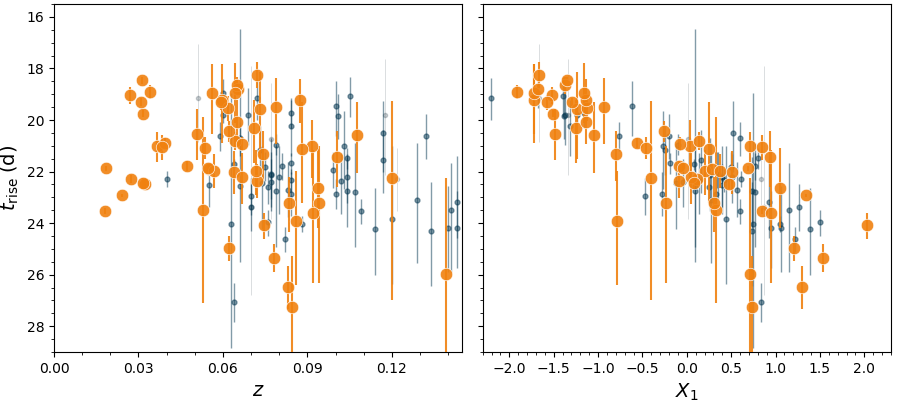

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4), sharey=True)

ax1.errorbar(salt_df.z_adopt.values[normal_plot], t_rise[normal_plot], 
             yerr=t_rise_unc[:,normal_plot], fmt='.', 
              color=color_dict['dark navy'], lw=0.5, alpha=0.2)
ax1.errorbar(salt_df.z_adopt.values[normal_good_plot], t_rise[normal_good_plot], 
             yerr=t_rise_unc[:,normal_good_plot], fmt='.',
             color=color_dict['blueberry'], lw=1, ms=7, alpha=0.5)
ax1.errorbar(salt_df.z_adopt.values[normal_good_host], t_rise[normal_good_host], 
             yerr=t_rise_unc[:,normal_good_host], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)

ax2.errorbar(salt_df.x1_salt2.values[normal_plot], t_rise[normal_plot], 
             yerr=t_rise_unc[:,normal_plot], fmt='.', 
              color=color_dict['dark navy'], lw=0.5, alpha=0.2)
ax2.errorbar(salt_df.x1_salt2.values[normal_good_plot], t_rise[normal_good_plot], 
             yerr=t_rise_unc[:,normal_good_plot], fmt='.',
             color=color_dict['blueberry'], lw=1, ms=7, alpha=0.5)
ax2.errorbar(salt_df.x1_salt2.values[normal_good_host], t_rise[normal_good_host], 
             yerr=t_rise_unc[:,normal_good_host], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)


ax1.set_ylabel(r'$t_\mathrm{rise}\;(\mathrm{d})$', fontsize=14)
ax1.set_ylim(29,15.5)
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.set_xlabel(r'$z$', fontsize=14)
ax1.set_xlim(0,0.145)
ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.xaxis.set_major_locator(MultipleLocator(0.03))


# ax2.set_ylabel(r'$t_\mathrm{rise}\;(\mathrm{d})$', fontsize=14)
# ax2.set_ylim(29,15.5)
# ax2.yaxis.set_minor_locator(MultipleLocator(0.5))
# ax2.yaxis.set_major_locator(MultipleLocator(2))

ax2.set_xlabel(r'$X_1$', fontsize=14)
ax2.set_xlim(-2.3,2.3)
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.xaxis.set_major_locator(MultipleLocator(0.5))

fig.subplots_adjust(left=0.06, right=0.99, top=0.99, bottom=0.12, wspace=0.05)
fig.savefig('../paper/figures/trise_z_tsquared.pdf')

In [70]:
z_cut = 0.04
low_cut = 0.04
high_cut = 0.065
low_z = np.where(salt_df.z_adopt <= z_cut)
mid_z = np.where((low_cut < salt_df.z_adopt) & (salt_df.z_adopt <= high_cut))
high_z = np.where(salt_df.z_adopt > high_cut)

good_host_low_z = np.intersect1d(normal_good_host, low_z[0])
good_host_mid_z = np.intersect1d(normal_good_host, mid_z[0])
good_host_high_z = np.intersect1d(normal_good_host, high_z[0])

<IPython.core.display.Javascript object>


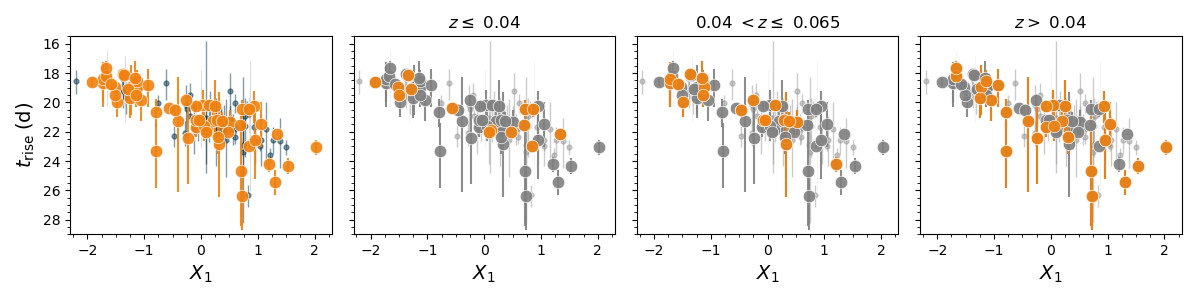

In [71]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, sharex=True, sharey=True, figsize=(12,3))

#  rise vs. redshift
ax0.errorbar(salt_df.x1_salt2.values[normal_plot], t_rise[normal_plot], 
             yerr=t_rise_unc[:,normal_plot], fmt='.', 
              color=color_dict['dark navy'], lw=0.5, alpha=0.2)
ax0.errorbar(salt_df.x1_salt2.values[normal_good_plot], t_rise[normal_good_plot], 
             yerr=t_rise_unc[:,normal_good_plot], fmt='.',
             color=color_dict['blueberry'], lw=1, ms=7, alpha=0.5)
ax0.errorbar(salt_df.x1_salt2.values[normal_good_host], t_rise[normal_good_host], 
             yerr=t_rise_unc[:,normal_good_host], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)

for ax in [ax1, ax2, ax3]:
    ax.errorbar(salt_df.x1_salt2.values[normal_plot], t_rise[normal_plot], 
                yerr=t_rise_unc[:,normal_plot], fmt='.', 
                color='0.7', lw=0.5, alpha=0.2)
    ax.errorbar(salt_df.x1_salt2.values[normal_good_plot], t_rise[normal_good_plot], 
                yerr=t_rise_unc[:,normal_good_plot], fmt='.',
                color='0.6', lw=1, ms=7, alpha=0.5)
    ax.errorbar(salt_df.x1_salt2.values[normal_good_host], t_rise[normal_good_host], 
                yerr=t_rise_unc[:,normal_good_host], fmt='o', ms=9,
                color='0.5', mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)
    ax.set_xlabel(r'$X_1$', fontsize=14)

ax1.errorbar(salt_df.x1_salt2.values[good_host_low_z], t_rise[good_host_low_z], 
             yerr=t_rise_unc[:,good_host_low_z], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)
ax1.set_title(r'$z \leq$ {}'.format(z_cut),fontsize=12)
ax2.errorbar(salt_df.x1_salt2.values[good_host_mid_z], t_rise[good_host_mid_z], 
             yerr=t_rise_unc[:,good_host_mid_z], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)
ax2.set_title(r'{} $< z \leq$ {}'.format(low_cut, high_cut),fontsize=12)
ax3.errorbar(salt_df.x1_salt2.values[good_host_high_z], t_rise[good_host_high_z], 
             yerr=t_rise_unc[:,good_host_high_z], fmt='o', ms=9,
             color=color_dict['orange'], mec='w', mew=0.5, lw=1.5, alpha=0.9, zorder=10)
ax3.set_title(r'$z >$ {}'.format(z_cut),fontsize=12)

ax0.set_ylabel(r'$t_\mathrm{rise}\;(\mathrm{d})$', fontsize=14)
ax0.set_ylim(29,15.5)
ax0.yaxis.set_minor_locator(MultipleLocator(0.5))
ax0.yaxis.set_major_locator(MultipleLocator(2))

ax0.set_xlabel(r'$X_1$', fontsize=14)
ax0.set_xlim(-2.3,2.3)
ax0.xaxis.set_minor_locator(MultipleLocator(0.25))
ax0.xaxis.set_major_locator(MultipleLocator(1))

fig.tight_layout()

In [34]:
print('Correlating X1 and rise time:')
rho, p = spearmanr(salt_df.x1_salt2.values[normal_good_host], t_rise[normal_good_host])
print('\tFor good w/ hosts: rho = {:.4f}, p = {:.4f}'.format(rho, p))
rho, p = spearmanr(salt_df.x1_salt2.values[normal_good], t_rise[normal_good])
print('\tFor good: rho = {:.4f}, p = {:.4f}'.format(rho, p))
rho, p = spearmanr(salt_df.x1_salt2.values, t_rise)
print('\tFor all: rho = {:.4f}, p = {:.4f}'.format(rho, p))


Correlating X1 and rise time:
	For good w/ hosts: rho = 0.8387, p = 0.0000
	For good: rho = 0.8025, p = 0.0000
	For all: rho = 0.8367, p = 0.0000


##  Make final PDF plots

In [73]:
# sn = 'ZTF18aazabmh'

<IPython.core.display.Javascript object>


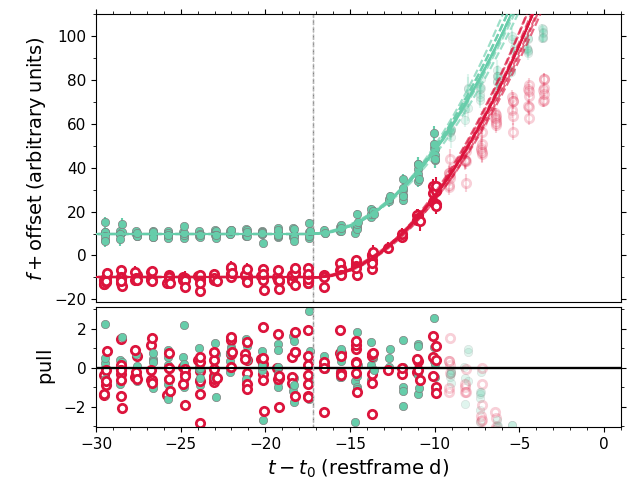

In [74]:
paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{r, g}$',
             r"$A'_r$", r'$\alpha_{r, r}$']
thin_by = 100
rel_flux_cutoff = 0.4

h5_file = info_path + 'big_unc/{}_emcee_40_tsquared.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)

burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data, plot_obs = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff, 
                                                                     return_masked=True)

adjust_samp = np.zeros((np.shape(samples)[0],2+np.shape(samples)[1]))
for alpha  in [2,4]:
    adjust_samp[:,alpha] = np.ones(len(samples))*2
for param_num in range(len(samples[0])):
    if param_num < 2:
        adjust_samp[:,param_num]  = samples[:,param_num]
    elif param_num == 2:
        adjust_samp[:,param_num+1]  = samples[:,param_num]
    elif param_num > 2:
        adjust_samp[:,param_num+2]  = samples[:,param_num]


max_posterior = adjust_samp[np.argmax(lnpost)]
haha = plot_both_filt(max_posterior, t_data, f_data, f_unc_data, fcqfid_data, plot_obs,
                      adjust_samp, np.random.choice(range(len(samples)), 8, replace=False))
# haha.savefig(info_path + 'big_unc/{}_model_lc.pdf'.format(sn))